# Model the density of the N-rich stars selected by Ricky in APOGEE DR17

Cuts that Ricardo sent for his N-rich star sample

mask_al = ( (asn >= 50) & (ateff > 3000) & (ateff < 5000) & \
        (alogg < 3.6) & (alogg > -1) & ((aedist/adist)<0.20) & \
        (gcid_mask==True) & (afe > -10) & (amg > -10) & (amn > -10) & \
        (aEnergy < 0.0) & (aLz < 1.e4) & (aLz > -1.e4) & \
        (asflag == 0) & (an < 10) & (an > -10) & (ac > -10) & \
        (ac < 10) & (aal > -10) & (aal < 10) & (sgid_mask==True))

In [1]:
import os
import sys

os.environ['DUST_DIR'] = '/Users/dhortadarrington/Packages/mwdust/'

import numpy as np
import matplotlib.pyplot as plt
import utils
import densprofiles
from galpy.util import coords
import mwdust
import tqdm
import emcee
import dill as pickle
import multiprocessing
import scipy.optimize as op
from scipy import interpolate
from sklearn.mixture import GaussianMixture
from isodist import FEH2Z, Z2FEH
import corner
import safe_colours
import astropy.io.fits as fits

safe_colours = safe_colours.initialise()
col_dict = safe_colours.distinct_named()
cm_rainbow = safe_colours.colourmap('rainbow')
cm_heat = safe_colours.colourmap('heat')
cm_diverging = safe_colours.colourmap('diverging')

columnwidth = 240./72.27
textwidth = 504.0/72.27

from matplotlib import rc
# rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('font',**{'family':'serif','serif':['Times']})
rc('text', usetex=True)
import nmmn.plots
wolfram=nmmn.plots.wolframcmap() # for Mathematica's cmap
parula=nmmn.plots.parulacmap() # for MATLAB's cmap
turbo=nmmn.plots.turbocmap() # Turbo
import warnings
warnings.filterwarnings('ignore')

os.environ['RESULTS_VERS'] = 'dr17'
os.environ['SDSS_LOCAL_SAS_MIRROR'] = '/Users/dhortadarrington/Documents/Projects/halo-density/data/'
os.environ['ISODIST_DATA'] = '/Users/dhortadarrington/Packages/isodist/'


A new version of galpy (1.10.0) is available, please upgrade using pip/conda/... to get the latest features and bug fixes!


In [2]:
os.environ["PATH"]='/opt/homebrew/bin:/opt/homebrew/sbin:/Users/dhortadarrington/opt/\
    anaconda3/bin:/Users/dhortadarrington/opt/anaconda3/condabin:/usr/local/bin:/usr/bin:/bin:/usr/sbin:/sbin'


In [137]:
# LOAD THE DATA
path = '/Users/dhortadarrington/Documents/Projects/halo-density/data/dr17_dr3_McMillan_astroNN_rev1.fits'
tb = fits.open(path)
allstar = tb[1].data 

path2 = '/Users/dhortadarrington/Documents/Projects/halo-density/n-rich-schiavon-files/IDs_acc_hialph_30oct2024.fits'
tb2 = fits.open(path2)
nrich_acc_higha = tb2[1].data 

path3 = '/Users/dhortadarrington/Documents/Projects/halo-density/n-rich-schiavon-files/IDs_insitu_30oct2024_bufm05.fits'
tb3 = fits.open(path3)
nrich_insitu = tb3[1].data 

path4 = '/Users/dhortadarrington/Documents/Projects/halo-density/n-rich-schiavon-files/IDs_acc_mealph_30oct2024.fits'
tb4 = fits.open(path4)
nrich_acc_mealph = tb4[1].data 

path5 = '/Users/dhortadarrington/Documents/Projects/halo-density/n-rich-schiavon-files/IDs_acc_loalph_30oct2024.fits'
tb5 = fits.open(path5)
nrich_acc_loalph = tb5[1].data 



In [138]:
len(nrich_acc_higha), len(nrich_insitu), len(nrich_acc_mealph), len(nrich_acc_loalph)

(102, 107, 97, 42)

In [139]:
m_acc_higha = np.isin(list(allstar['APOGEE_ID_1']), list(nrich_acc_higha['APOGEE_ID']))
m_acc_mea = np.isin(list(allstar['APOGEE_ID_1']), list(nrich_acc_mealph['APOGEE_ID']))
m_acc_lowa = np.isin(list(allstar['APOGEE_ID_1']), list(nrich_acc_loalph['APOGEE_ID']))
m_insitu = np.isin(list(allstar['APOGEE_ID_1']), list(nrich_insitu['APOGEE_ID']))
print(len(allstar[m_acc_higha]), len(allstar[m_acc_mea]),\
     len(allstar[m_acc_lowa]), len(allstar[m_insitu]))

112 108 55 122


In [140]:
m_un_higha = np.where(np.unique(allstar['APOGEE_ID_1'][m_acc_higha]))[0]
m_un_mea = np.where(np.unique(allstar['APOGEE_ID_1'][m_acc_mea]))[0]
m_un_lowa = np.where(np.unique(allstar['APOGEE_ID_1'][m_acc_lowa]))[0]
m_un_insitu = np.where(np.unique(allstar['APOGEE_ID_1'][m_insitu]))[0]

In [141]:
print(len(allstar[m_acc_higha][m_un_higha]), len(allstar[m_acc_mea][m_un_mea]),\
     len(allstar[m_acc_lowa][m_un_lowa]), len(allstar[m_insitu][m_un_insitu]))

102 97 42 107


In [142]:
loadpath =  '/Users/dhortadarrington/Documents/Projects/halo-density/sav/'
accreted_mask = np.load(loadpath+'accreted_mask_new-inner.npy')
parent_mask = np.load(loadpath+'parent_mask_new-inner.npy')


In [113]:
# lowfehbins = np.array([-3.,-1.6])
# lowafebins = np.array([0.,0.2,0.4])
ebins = [0.,0.7,1.]
ndistmods=301
minmax_distmods=[6.,17.] # from 0.1 to 25 kpc
nthreads = int(multiprocessing.cpu_count()//2)
isorec = utils.generate_lowfeh_isogrid()
dmap = mwdust.Combined19()
distmods = np.linspace(minmax_distmods[0], minmax_distmods[1], ndistmods)
ds = 10.**(distmods/5-2)

force = False
if os.path.exists('../sav/apogeeCombinedSF_DR17.dat') and not force:
    with open('../sav/apogeeCombinedSF_DR17.dat', 'rb') as f:
        apo = pickle.load(f)

if os.path.exists('../essf/effsel_grid_dr17-nrich-Schiavon.dat') and not force:
    with open('../essf/effsel_grid_dr17-nrich-Schiavon.dat', 'rb') as f:
        outarea = pickle.load(f)

100%|███████████████████████████████████████████| 30/30 [00:01<00:00, 25.32it/s]


# Model the density

In [12]:
#remove fields where effsel == 0 everywhere?
goodfields = ~np.all(outarea < 1e-9, axis=1)
# remove fields in the bulge direction
aposel_glons = np.array([apo.glonGlat(x)[0][0] for x in apo._locations])
aposel_glats = np.array([apo.glonGlat(x)[1][0] for x in apo._locations])
# bulgeindx = ((aposel_glons > 355) | (aposel_glons < 5)) & (np.fabs(aposel_glats) < 5)
# goodindx = goodfields & ~bulgeindx & (apo._locations != 5093) #remove bad fields
goodindx_eff = goodfields & (apo._locations != 5093) #remove bad fields
goodlocs = apo._locations[goodindx_eff]
# remove data not in the final field list
good_datamask = [allstar['LOCATION_ID'][i] in goodlocs for i in tqdm.tqdm_notebook(range(len(allstar)))]
# good_datamask *= data['weighted_dist']/data['weighted_dist_error'] > 5.


  0%|          | 0/733900 [00:00<?, ?it/s]

In [13]:
X, Y, Z = allstar['X']*8.275, allstar['Y']*8.275, allstar['Z']*8.275

In [14]:
Rgrid, phigrid, zgrid = utils.Rphizgrid(apo, distmods)

import cmasher as cm
#Calculate the XYZ and Rphiz coordinates of the two samples and the rest of APOGEE DR14.
def allstar_to_coords(dat):
    l, b, d = dat['GLON'], dat['GLAT'], dat['weighted_dist']/1e3
    XYZ = coords.lbd_to_XYZ(l,b,d, degree=True)
    Rphiz = coords.XYZ_to_galcencyl(XYZ[:,0], XYZ[:,1], XYZ[:,2], Xsun=8.275, Zsun=0.02)
    return XYZ, Rphiz
XYZ, Rphiz = allstar_to_coords(allstar)

In [15]:
def pdistmod_model(densfunc, params, effsel, returnrate=False):
    rate = (densfunc(Rgrid[goodindx_eff],phigrid[goodindx_eff],zgrid[goodindx_eff],params=params))*effsel[goodindx_eff]*ds**3
    
    pdt = np.sum(rate,axis=0)
    pd = pdt/np.sum(pdt)/(distmods[1]-distmods[0])
    if returnrate:
        return pd, pdt, rate
    return pd, pdt

In [16]:
#these functions are necessary to do the fits to the APOGEE giants. They could be in with the utils, but for simplicity, I just put them here!
from scipy import integrate

#first need to get the minimum J-K in each field
jkmins = np.array([apo.JKmin(apo._locations[i]) for i in range(len(apo._locations))])
jkmaxs = np.array([apo.JKmax(apo._locations[i]) for i in range(len(apo._locations))])

def calc_bic_loglike(mask, params, fehrange=[-2.5,0.], effsel=outarea, model = densprofiles.spherical):
    loglike = utils.loglike(params,model, effsel[goodindx_eff]*ds**3.*np.log(10)/5.*(distmods[1]-distmods[0]), Rgrid[goodindx_eff], phigrid[goodindx_eff], zgrid[goodindx_eff], Rphiz[:,0][mask1][mask2],Rphiz[:,1][mask1][mask2], Rphiz[:,2][mask1][mask2])
    print((sum(mask)))
    bic = sum(params)*np.log(sum(mask))-2*loglike
    return bic, loglike
    
def fit_bin_mask(mask1, mask2, fehrange=[-2.5,0.], effsel=outarea, model=densprofiles.spherical, just_MLE=True, just_MCMC=False, mass=False, init= [2.], ncut=100, analytic=False, inttype='spherical'):
    '''
    Fits the stars defined by a mask to the APOGEE low metallicity sample
    IN:
    mask - must be same length as gaia2_matches[omask], and must have Fe/H limits that go into fehrange.
    fehrange - the range in Fe/H spanned by the sample defined by mask
    effsel - the effective selection function corresponding to the sample in mask
    model - the density model to be fit
    just_MLE - do the Maximum Likelihood and return opt
    just_MCMC - do the MCMC
    mass - also compute the total mass
    init - initial input parameters for the density model
    ncut - number of samples to cut from each MCMC chain
    analytic - compute the mass integral analytically (only works for spherical density models)
    inttype - the coordinate scheme for the integration grid for mass computation
    OUTPUT:
    opt - opt from op.minimize
    samples - MCMC samples
    masses - MC samples of mass
    facs - the normalisation factor corresponding to each mass sample
    '''
    #needs goodindx_eff defined above. 'mask' must be same length as gaia2_matches[omask].
    print(len(Rphiz[mask1][mask2]))
    if not just_MCMC:
        # do MLE. 
        mloglike = lambda x: utils.mloglike(x,model, effsel[goodindx_eff]*ds**3.*np.log(10)/5.*(distmods[1]-distmods[0]), Rgrid[goodindx_eff], phigrid[goodindx_eff], zgrid[goodindx_eff], Rphiz[:,0][mask1][mask2],Rphiz[:,1][mask1][mask2], Rphiz[:,2][mask1][mask2])
        print(mloglike)
        opt = op.fmin(lambda x: utils.mloglike(x,model, effsel[goodindx_eff]*ds**3.*np.log(10)/5.*(distmods[1]-distmods[0]), Rgrid[goodindx_eff], phigrid[goodindx_eff], zgrid[goodindx_eff], Rphiz[:,0][mask1][mask2],Rphiz[:,1][mask1][mask2], Rphiz[:,2][mask1][mask2]), init, full_output=True)
        print(opt[0])
        if just_MLE:
            return opt
    # do MCMC initialised from best result from MLE or from init params given
    ndim, nwalkers = len(init), 100
    if just_MCMC:
        pos = [init + 1e-3*np.random.randn(ndim) for i in range(nwalkers)]
    else:
        pos = [opt[0] + 1e-3*np.random.randn(ndim) for i in range(nwalkers)]
    nit = 1000
    threads = 4
    #only effsel for good fields
    effsel_in = effsel[goodindx_eff]*ds**3*np.log(10)/5.*(distmods[1]-distmods[0])
    #re-build Rphiz grid
    Rgrid_in, phigrid_in, zgrid_in = Rgrid[goodindx_eff], phigrid[goodindx_eff], zgrid[goodindx_eff]
    #set up sampler and do the sampling.
    sampler = emcee.EnsembleSampler(nwalkers, ndim, utils.loglike, 
                                        args=(model, effsel_in, Rgrid_in, phigrid_in, zgrid_in, Rphiz[:,0][mask1][mask2], Rphiz[:,1][mask1][mask2], Rphiz[:,2][mask1][mask2]), 
                                        threads=threads,moves=[(emcee.moves.DEMove(), 0.8), (emcee.moves.DEMove(), 0.2)])
    for i, result in tqdm.tqdm_notebook(enumerate(sampler.sample(pos, iterations=nit)), total=nit):
        continue
    #cut ncut samples from each chain
    samples = sampler.chain[:, :, :].reshape((-1, ndim))
    if not mass:
        if just_MCMC:
            return samples
        else:
            return opt, samples, sampler
        
    isofactors = np.zeros(len(effsel[goodindx_eff]))
    for i in tqdm.tqdm_notebook(range(len(isofactors))):   
        isomask = (Z2FEH(isorec['Zini']) > fehrange[0]) & (Z2FEH(isorec['Zini']) < fehrange[1]) & (isorec['Jmag']-isorec['Ksmag'] > jkmins[goodindx_eff][i]) & (isorec['logg'] > -1.) & (isorec['logg'] < 3.6) & (isorec['logAge'] > 10) & (10**(isorec['logTe']) > 3000.) & (10**(isorec['logTe']) < 5000.)
        avmass = utils.average_mass(isorec[isomask], lowfehgrid=True)
        isomask = (Z2FEH(isorec['Zini']) > fehrange[0]) & (Z2FEH(isorec['Zini']) < fehrange[1]) & (isorec['logAge'] > 10)  #& (isorec['J']-isorec['K'] > 0.3) & (isorec['logg'] < 3) & (isorec['logg'] > 1)
        massratio = utils.mass_ratio(isorec[isomask], lowfehgrid=True, minjk=jkmins[goodindx_eff][i], maxjk=jkmaxs[goodindx_eff][i])
        isofactors[i] = avmass/massratio #fraction of stellar mass in giants
        #set up grid for integration
        rthetaphigrid = np.mgrid[0.1:30.:150j,0:np.pi:150j,0:2*np.pi:150j]
        dr = (30.-0.1)/149
        dtheta = (np.pi-0.)/149
        dphi = (2*np.pi-0.)/149
        shape = np.shape(rthetaphigrid.T)
        rthetaphigrid = rthetaphigrid.T.reshape(np.product(shape[:3]),shape[3])
        deltafactor = rthetaphigrid[:,0]**2*np.sin(rthetaphigrid[:,1])*dr*dtheta*dphi
        x = rthetaphigrid[:,0]*np.sin(rthetaphigrid[:,1])*np.cos(rthetaphigrid[:,2])
        y = rthetaphigrid[:,0]*np.sin(rthetaphigrid[:,1])*np.sin(rthetaphigrid[:,2])
        z = rthetaphigrid[:,0]*np.cos(rthetaphigrid[:,1])
        xyzgrid = np.dstack([x,y,z])[0]
        rphizgrid = coords.rect_to_cyl(xyzgrid[:,0], xyzgrid[:,1], xyzgrid[:,2])
        rphizgrid = np.dstack([rphizgrid[0],rphizgrid[1],rphizgrid[2]])[0]
    if model is densprofiles.broken_pw or model is densprofiles.triple_pw or model is densprofiles.spl_pw or model is densprofiles.einasto or model is densprofiles.triaxial_single_cutoff_zvecpa_plusexpdisk:
        masses = np.zeros((400,3))
    else:
        masses = np.zeros(400)
    facs = np.zeros(400)
    for ii,params in tqdm.tqdm_notebook(enumerate(samples[np.random.choice(len(samples), 400, replace=False)]), total=400):
        rate = model(Rgrid[goodindx_eff],phigrid[goodindx_eff],zgrid[goodindx_eff],params=params)*effsel[goodindx_eff]*ds**3*np.log(10)/5.*(distmods[1]-distmods[0])
        sumrate = np.sum(rate.T/isofactors) #conversion factor between RGB number counts and total stellar mass
        norm = len(Rphiz[mask1][mask2])/sumrate
        fac = norm*(180./np.pi)**2  #conversion factor between RGB number counts and total stellar mass accounted for density normalisation
        if analytic:
            #only for spherical power law!
            rsun = np.sqrt(8.275**2+0.02**2)
            min_r = 0.1
            max_r = 30.
            alpha = params[0]
            integral = 4*np.pi*((rsun**alpha*max_r**(3-alpha))/(3-alpha)-(rsun**alpha*min_r**(3-alpha))/(3-alpha))
            masses[ii] = integral*fac
        elif model is densprofiles.broken_pw or model is densprofiles.triple_pw or model is densprofiles.spl_pw or model is densprofiles.einasto or model is densprofiles.triaxial_single_cutoff_zvecpa_plusexpdisk:
                denstxyz = model(rphizgrid[:,0],rphizgrid[:,1],rphizgrid[:,2], params=params, split=True)
                halodens = denstxyz[0]*fac
                diskdens = denstxyz[1]*fac
                fulldens = model(rphizgrid[:,0],rphizgrid[:,1],rphizgrid[:,2], params=params)*fac
                masses[ii] = np.sum(halodens*deltafactor), np.sum(diskdens*deltafactor), np.sum(fulldens*deltafactor)        
        elif model is densprofiles.axisymmetric or model is densprofiles.justexpdisk or model is densprofiles.plummer:
                denstxyz = model(rphizgrid[:,0],rphizgrid[:,1],rphizgrid[:,2], params=params)
                fulldens = model(rphizgrid[:,0],rphizgrid[:,1],rphizgrid[:,2], params=params)*fac
                masses[ii] = np.sum(fulldens*deltafactor)
        facs[ii] = fac
    if just_MCMC:
        return samples, masses, facs
    return opt, samples,sampler, masses, facs


In [17]:
mask_good_d = (allstar['weighted_dist']/allstar['weighted_dist_error'])>10
print(len(allstar[mask_good_d]))
print(len(allstar))

629864
733900


# Check their spatial distributions

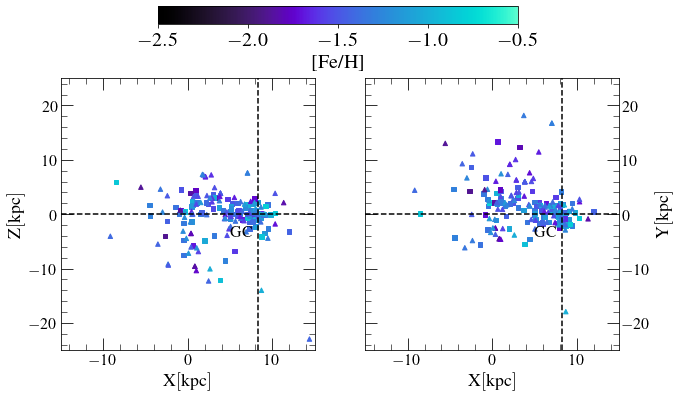

In [171]:
import cmasher as cm
from matplotlib.colors import LogNorm

#Plot the spatial distribution of the stars in x-y and x-z
fig, ax = plt.subplots(1,2,figsize=(10,5), facecolor='white')
# fig.set_size_inches(textwidth,columnwidth)
plt.rc('font',family='serif',size=14)
# mask = (allstar_f['FE_H'] < -1.) & good_datamask & (allstar_f['C_FE'] < 0.15) &  (allstar_f['N_FE'] >= 0.5) & (allstar_f['FE_H'] > -3.)  & (allstar_f['LOGG'] < 3.) & (allstar_f['LOGG'] > 1.)
# ax[0].hist2d(X[mask],Y[mask],bins=200,cmap='binary',norm=LogNorm())
# ax[0].scatter(XYZ[:,0][goodindx],XYZ[:,2][goodindx], c='k', s=2, lw=0., alpha=0.5, zorder=-1, rasterized=True)
color = ax[0].scatter(X[m_acc_higha][m_un_higha],Y[m_acc_higha][m_un_higha], c=allstar['FE_H'][m_acc_higha][m_un_higha], s=20, cmap=cm.cosmic, rasterized=True,vmin=-2.5,vmax=-0.5, marker='s')
ax[0].scatter(X[m_acc_mea][m_un_mea],Y[m_acc_mea][m_un_mea], c=allstar['FE_H'][m_acc_mea][m_un_mea], s=20, cmap=cm.cosmic, rasterized=True,vmin=-2.5,vmax=-0.5, marker='^')
# ax[0].scatter(X[m_insitu][m_un_insitu],Y[m_insitu][m_un_insitu], c=allstar['FE_H'][m_insitu][m_un_insitu], s=20, cmap=cm.cosmic, rasterized=True,vmin=-2.5,vmax=-0.5, marker='.')
ax[0].axvline(8.275, c='Black', linestyle='dashed')
ax[0].axhline(0., c='Black', linestyle='dashed')
# ax[0].plot(8+5*x1,5*x2,c='k',ls='dashed',lw=0.5)
# ax[0].plot(8+10*x1,10*x2,c='k',ls='dashed',lw=0.5,label='5 kpc')
# ax[0].plot(8+15*x1,15*x2,c='k',ls='dashed',lw=0.5)
# ax[0].plot(8+20*x1,20*x2,c='k',ls='dashed',lw=0.5)
ax[0].set_ylim(-25,25)
ax[0].set_xlim(-15,15)
# ax[0].legend(loc='lower left',frameon=False)
# ax[1].hist2d(X[mask],Y[mask],bins=200,cmap='binary',norm=LogNorm())
# ax[1].scatter(XYZ[:,0][goodindx],XYZ[:,1][goodindx], c='k', s=2, lw=0., alpha=0.5, zorder=-1, rasterized=True)
color = ax[1].scatter(X[m_acc_higha][m_un_higha],Z[m_acc_higha][m_un_higha], c=allstar['FE_H'][m_acc_higha][m_un_higha], s=20, cmap=cm.cosmic, rasterized=True,vmin=-2.5,vmax=-0.5, marker='s')
ax[1].scatter(X[m_acc_mea][m_un_mea],Z[m_acc_mea][m_un_mea], c=allstar['FE_H'][m_acc_mea][m_un_mea], s=20, cmap=cm.cosmic, rasterized=True,vmin=-2.5,vmax=-0.5, marker='^')
# ax[1].scatter(X[m_insitu][m_un_insitu],Z[m_insitu][m_un_insitu], c=allstar['FE_H'][m_insitu][m_un_insitu], s=20, cmap=cm.cosmic, rasterized=True,vmin=-2.5,vmax=-0.5, marker='.')
# ax[1].plot(8+5*x1,5*x2,c='k',ls='dashed',lw=0.5)
# ax[1].plot(8+10*x1,10*x2,c='k',ls='dashed',lw=0.5,label='5 kpc')
# ax[1].plot(8+15*x1,15*x2,c='k',ls='dashed',lw=0.5)
# ax[1].plot(8+20*x1,20*x2,c='k',ls='dashed',lw=0.5)
ax[1].axvline(8.275, c='Black', linestyle='dashed')
ax[1].axhline(0., c='Black', linestyle='dashed')
ax[1].set_ylim(-25,25)
ax[1].set_xlim(-15,15)
ax[1].yaxis.tick_right()
ax[1].yaxis.set_label_position('right')
ax[0].set_xlabel(r'$\mathrm{X} \mathrm{[kpc]}$', fontsize=18)
ax[1].set_xlabel(r'$\mathrm{X} \mathrm{[kpc]}$', fontsize=18)
ax[0].set_ylabel(r'$\mathrm{Z} \mathrm{[kpc]}$', fontsize=18)
ax[1].set_ylabel(r'$\mathrm{Y} \mathrm{[kpc]}$', fontsize=18)
ax[0].text(5.,-4,r'GC', fontsize=16)
ax[1].text(5.,-4,r'GC', fontsize=16)
ax[0].tick_params(which='major',labelsize=16,direction='in',top=True,right=True,length=12)
ax[0].tick_params(which='minor', length=6, direction='in',top=True,right=True)
ax[0].minorticks_on()
ax[1].tick_params(which='major',labelsize=16,direction='in',top=True, left=True,right=True,length=12)
ax[1].tick_params(which='minor', length=6, direction='in',top=True, left=True,right=True)
ax[1].minorticks_on()
# plt.savefig('../plots/spatial2.pdf', format='pdf', dpi=400, bbox_inches='tight')

cbar_ax = fig.add_axes([0.26, 1.03, 0.5,0.05])
cbar = fig.colorbar(color, cax = cbar_ax,orientation='horizontal')
# cbar.set_label(label=r'L$_{z}$ [kpc kms$^{-1}$]',fontsize=20)
cbar.set_label(label=r'[Fe/H]',fontsize=20)
cbar.ax.tick_params(labelsize=20)

# plt.savefig('../plots/spatial_new.png', format='png', dpi=400, bbox_inches='tight',rasterized=True)


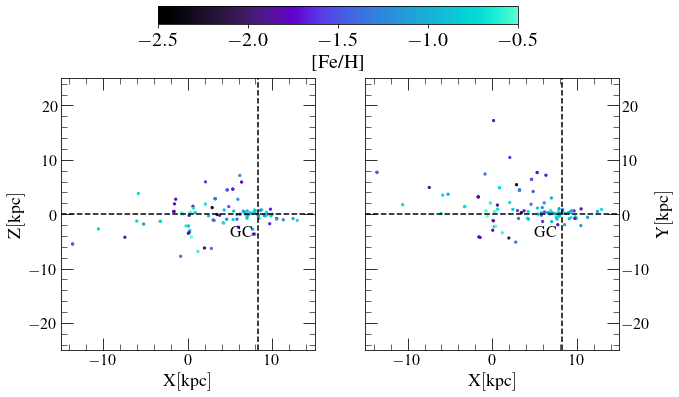

In [170]:
import cmasher as cm
from matplotlib.colors import LogNorm

#Plot the spatial distribution of the stars in x-y and x-z
fig, ax = plt.subplots(1,2,figsize=(10,5), facecolor='white')
# fig.set_size_inches(textwidth,columnwidth)
plt.rc('font',family='serif',size=14)
# mask = (allstar_f['FE_H'] < -1.) & good_datamask & (allstar_f['C_FE'] < 0.15) &  (allstar_f['N_FE'] >= 0.5) & (allstar_f['FE_H'] > -3.)  & (allstar_f['LOGG'] < 3.) & (allstar_f['LOGG'] > 1.)
# ax[0].hist2d(X[mask],Y[mask],bins=200,cmap='binary',norm=LogNorm())
# ax[0].scatter(XYZ[:,0][goodindx],XYZ[:,2][goodindx], c='k', s=2, lw=0., alpha=0.5, zorder=-1, rasterized=True)
# color = ax[0].scatter(X[m_acc_higha][m_un_higha],Y[m_acc_higha][m_un_higha], c=allstar['FE_H'][m_acc_higha][m_un_higha], s=20, cmap=cm.cosmic, rasterized=True,vmin=-2.5,vmax=-0.5, marker='s')
# ax[0].scatter(X[m_acc_mea][m_un_mea],Y[m_acc_mea][m_un_mea], c=allstar['FE_H'][m_acc_mea][m_un_mea], s=20, cmap=cm.cosmic, rasterized=True,vmin=-2.5,vmax=-0.5, marker='^')
ax[0].scatter(X[m_insitu][m_un_insitu],Y[m_insitu][m_un_insitu], c=allstar['FE_H'][m_insitu][m_un_insitu], s=20, cmap=cm.cosmic, rasterized=True,vmin=-2.5,vmax=-0.5, marker='.')
ax[0].axvline(8.275, c='Black', linestyle='dashed')
ax[0].axhline(0., c='Black', linestyle='dashed')
# ax[0].plot(8+5*x1,5*x2,c='k',ls='dashed',lw=0.5)
# ax[0].plot(8+10*x1,10*x2,c='k',ls='dashed',lw=0.5,label='5 kpc')
# ax[0].plot(8+15*x1,15*x2,c='k',ls='dashed',lw=0.5)
# ax[0].plot(8+20*x1,20*x2,c='k',ls='dashed',lw=0.5)
ax[0].set_ylim(-25,25)
ax[0].set_xlim(-15,15)
# ax[0].legend(loc='lower left',frameon=False)
# ax[1].hist2d(X[mask],Y[mask],bins=200,cmap='binary',norm=LogNorm())
# ax[1].scatter(XYZ[:,0][goodindx],XYZ[:,1][goodindx], c='k', s=2, lw=0., alpha=0.5, zorder=-1, rasterized=True)
# color = ax[1].scatter(X[m_acc_higha][m_un_higha],Z[m_acc_higha][m_un_higha], c=allstar['FE_H'][m_acc_higha][m_un_higha], s=20, cmap=cm.cosmic, rasterized=True,vmin=-2.5,vmax=-0.5, marker='s')
# ax[1].scatter(X[m_acc_mea][m_un_mea],Z[m_acc_mea][m_un_mea], c=allstar['FE_H'][m_acc_mea][m_un_mea], s=20, cmap=cm.cosmic, rasterized=True,vmin=-2.5,vmax=-0.5, marker='^')
ax[1].scatter(X[m_insitu][m_un_insitu],Z[m_insitu][m_un_insitu], c=allstar['FE_H'][m_insitu][m_un_insitu], s=20, cmap=cm.cosmic, rasterized=True,vmin=-2.5,vmax=-0.5, marker='.')
# ax[1].plot(8+5*x1,5*x2,c='k',ls='dashed',lw=0.5)
# ax[1].plot(8+10*x1,10*x2,c='k',ls='dashed',lw=0.5,label='5 kpc')
# ax[1].plot(8+15*x1,15*x2,c='k',ls='dashed',lw=0.5)
# ax[1].plot(8+20*x1,20*x2,c='k',ls='dashed',lw=0.5)
ax[1].axvline(8.275, c='Black', linestyle='dashed')
ax[1].axhline(0., c='Black', linestyle='dashed')
ax[1].set_ylim(-25,25)
ax[1].set_xlim(-15,15)
ax[1].yaxis.tick_right()
ax[1].yaxis.set_label_position('right')
ax[0].set_xlabel(r'$\mathrm{X} \mathrm{[kpc]}$', fontsize=18)
ax[1].set_xlabel(r'$\mathrm{X} \mathrm{[kpc]}$', fontsize=18)
ax[0].set_ylabel(r'$\mathrm{Z} \mathrm{[kpc]}$', fontsize=18)
ax[1].set_ylabel(r'$\mathrm{Y} \mathrm{[kpc]}$', fontsize=18)
ax[0].text(5.,-4,r'GC', fontsize=16)
ax[1].text(5.,-4,r'GC', fontsize=16)
ax[0].tick_params(which='major',labelsize=16,direction='in',top=True,right=True,length=12)
ax[0].tick_params(which='minor', length=6, direction='in',top=True,right=True)
ax[0].minorticks_on()
ax[1].tick_params(which='major',labelsize=16,direction='in',top=True, left=True,right=True,length=12)
ax[1].tick_params(which='minor', length=6, direction='in',top=True, left=True,right=True)
ax[1].minorticks_on()
# plt.savefig('../plots/spatial2.pdf', format='pdf', dpi=400, bbox_inches='tight')

cbar_ax = fig.add_axes([0.26, 1.03, 0.5,0.05])
cbar = fig.colorbar(color, cax = cbar_ax,orientation='horizontal')
# cbar.set_label(label=r'L$_{z}$ [kpc kms$^{-1}$]',fontsize=20)
cbar.set_label(label=r'[Fe/H]',fontsize=20)
cbar.ax.tick_params(labelsize=20)

# plt.savefig('../plots/spatial_new.png', format='png', dpi=400, bbox_inches='tight',rasterized=True)


# Model the density for all 4 samples with some initial set of density laws

Lets try the following laws: a SPL, an axisymmetric PL, triaxial PL, Ted's halo model, a Plummer model, and an exponential disc

In [144]:
# spl
opt_spl_acc_higha = op.fmin(lambda x: utils.mloglike(x,densprofiles.spherical, outarea[goodindx_eff]*ds**3.*np.log(10)/5.*(distmods[1]-distmods[0]), Rgrid[goodindx_eff], phigrid[goodindx_eff], zgrid[goodindx_eff], Rphiz[:,0][m_acc_higha][m_un_higha],Rphiz[:,1][m_acc_higha][m_un_higha], Rphiz[:,2][m_acc_higha][m_un_higha]), [2.], full_output=True)
opt_spl_acc_mea = op.fmin(lambda x: utils.mloglike(x,densprofiles.spherical, outarea[goodindx_eff]*ds**3.*np.log(10)/5.*(distmods[1]-distmods[0]), Rgrid[goodindx_eff], phigrid[goodindx_eff], zgrid[goodindx_eff], Rphiz[:,0][m_acc_mea][m_un_mea],Rphiz[:,1][m_acc_mea][m_un_mea], Rphiz[:,2][m_acc_mea][m_un_mea]), [2.], full_output=True)
opt_spl_acc_lowa = op.fmin(lambda x: utils.mloglike(x,densprofiles.spherical, outarea[goodindx_eff]*ds**3.*np.log(10)/5.*(distmods[1]-distmods[0]), Rgrid[goodindx_eff], phigrid[goodindx_eff], zgrid[goodindx_eff], Rphiz[:,0][m_acc_lowa][m_un_lowa],Rphiz[:,1][m_acc_lowa][m_un_lowa], Rphiz[:,2][m_acc_lowa][m_un_lowa]), [2.], full_output=True)
opt_spl_insitu = op.fmin(lambda x: utils.mloglike(x,densprofiles.spherical, outarea[goodindx_eff]*ds**3.*np.log(10)/5.*(distmods[1]-distmods[0]), Rgrid[goodindx_eff], phigrid[goodindx_eff], zgrid[goodindx_eff], Rphiz[:,0][m_insitu][m_un_insitu],Rphiz[:,1][m_insitu][m_un_insitu], Rphiz[:,2][m_insitu][m_un_insitu]), [2.], full_output=True)


Optimization terminated successfully.
         Current function value: 839.887230
         Iterations: 16
         Function evaluations: 32
Optimization terminated successfully.
         Current function value: 913.766081
         Iterations: 15
         Function evaluations: 30
Optimization terminated successfully.
         Current function value: 437.534872
         Iterations: 13
         Function evaluations: 26
Optimization terminated successfully.
         Current function value: 906.529340
         Iterations: 16
         Function evaluations: 32


In [145]:
# axi
opt_axi_acc_higha = op.fmin(lambda x: utils.mloglike(x,densprofiles.axisymmetric, outarea[goodindx_eff]*ds**3.*np.log(10)/5.*(distmods[1]-distmods[0]), Rgrid[goodindx_eff], phigrid[goodindx_eff], zgrid[goodindx_eff], Rphiz[:,0][m_acc_higha][m_un_higha],Rphiz[:,1][m_acc_higha][m_un_higha], Rphiz[:,2][m_acc_higha][m_un_higha]), [2.,0.1], full_output=True)
opt_axi_acc_mea = op.fmin(lambda x: utils.mloglike(x,densprofiles.axisymmetric, outarea[goodindx_eff]*ds**3.*np.log(10)/5.*(distmods[1]-distmods[0]), Rgrid[goodindx_eff], phigrid[goodindx_eff], zgrid[goodindx_eff], Rphiz[:,0][m_acc_mea][m_un_mea],Rphiz[:,1][m_acc_mea][m_un_mea], Rphiz[:,2][m_acc_mea][m_un_mea]), [2.,0.1], full_output=True)
opt_axi_acc_lowa = op.fmin(lambda x: utils.mloglike(x,densprofiles.axisymmetric, outarea[goodindx_eff]*ds**3.*np.log(10)/5.*(distmods[1]-distmods[0]), Rgrid[goodindx_eff], phigrid[goodindx_eff], zgrid[goodindx_eff], Rphiz[:,0][m_acc_lowa][m_un_lowa],Rphiz[:,1][m_acc_lowa][m_un_lowa], Rphiz[:,2][m_acc_lowa][m_un_lowa]), [2.,0.1], full_output=True)
opt_axi_insitu = op.fmin(lambda x: utils.mloglike(x,densprofiles.axisymmetric, outarea[goodindx_eff]*ds**3.*np.log(10)/5.*(distmods[1]-distmods[0]), Rgrid[goodindx_eff], phigrid[goodindx_eff], zgrid[goodindx_eff], Rphiz[:,0][m_insitu][m_un_insitu],Rphiz[:,1][m_insitu][m_un_insitu], Rphiz[:,2][m_insitu][m_un_insitu]), [2.,0.1], full_output=True)


Optimization terminated successfully.
         Current function value: 831.177004
         Iterations: 43
         Function evaluations: 81
Optimization terminated successfully.
         Current function value: 911.150248
         Iterations: 46
         Function evaluations: 88
Optimization terminated successfully.
         Current function value: 434.195346
         Iterations: 50
         Function evaluations: 93
Optimization terminated successfully.
         Current function value: 868.719274
         Iterations: 42
         Function evaluations: 81


In [146]:
# tri
opt_tri_acc_higha = op.fmin(lambda x: utils.mloglike(x,densprofiles.triaxial, outarea[goodindx_eff]*ds**3.*np.log(10)/5.*(distmods[1]-distmods[0]), Rgrid[goodindx_eff], phigrid[goodindx_eff], zgrid[goodindx_eff], Rphiz[:,0][m_acc_higha][m_un_higha],Rphiz[:,1][m_acc_higha][m_un_higha], Rphiz[:,2][m_acc_higha][m_un_higha]), [2.,0.1,0.1], full_output=True)
opt_tri_acc_mea = op.fmin(lambda x: utils.mloglike(x,densprofiles.triaxial, outarea[goodindx_eff]*ds**3.*np.log(10)/5.*(distmods[1]-distmods[0]), Rgrid[goodindx_eff], phigrid[goodindx_eff], zgrid[goodindx_eff], Rphiz[:,0][m_acc_mea][m_un_mea],Rphiz[:,1][m_acc_mea][m_un_mea], Rphiz[:,2][m_acc_mea][m_un_mea]), [2.,0.1,0.1], full_output=True)
opt_tri_acc_lowa = op.fmin(lambda x: utils.mloglike(x,densprofiles.triaxial, outarea[goodindx_eff]*ds**3.*np.log(10)/5.*(distmods[1]-distmods[0]), Rgrid[goodindx_eff], phigrid[goodindx_eff], zgrid[goodindx_eff], Rphiz[:,0][m_acc_lowa][m_un_lowa],Rphiz[:,1][m_acc_lowa][m_un_lowa], Rphiz[:,2][m_acc_lowa][m_un_lowa]), [2.,0.1,0.1], full_output=True)
opt_tri_insitu = op.fmin(lambda x: utils.mloglike(x,densprofiles.triaxial, outarea[goodindx_eff]*ds**3.*np.log(10)/5.*(distmods[1]-distmods[0]), Rgrid[goodindx_eff], phigrid[goodindx_eff], zgrid[goodindx_eff], Rphiz[:,0][m_insitu][m_un_insitu],Rphiz[:,1][m_insitu][m_un_insitu], Rphiz[:,2][m_insitu][m_un_insitu]), [2.,0.1,0.1], full_output=True)


Optimization terminated successfully.
         Current function value: 831.177006
         Iterations: 166
         Function evaluations: 289
Optimization terminated successfully.
         Current function value: 911.150248
         Iterations: 149
         Function evaluations: 263
Optimization terminated successfully.
         Current function value: 432.596684
         Iterations: 107
         Function evaluations: 192
Optimization terminated successfully.
         Current function value: 867.652087
         Iterations: 95
         Function evaluations: 168


In [147]:
# halo
opt_halo_acc_higha = op.fmin(lambda x: utils.mloglike(x,densprofiles.triaxial_single_cutoff_zvecpa_plusexpdisk, outarea[goodindx_eff]*ds**3.*np.log(10)/5.*(distmods[1]-distmods[0]), Rgrid[goodindx_eff], phigrid[goodindx_eff], zgrid[goodindx_eff], Rphiz[:,0][m_acc_higha][m_un_higha],Rphiz[:,1][m_acc_higha][m_un_higha], Rphiz[:,2][m_acc_higha][m_un_higha]), [2.,1.,0.5,0.5,0.,0.,0.,0.01], full_output=True)
opt_halo_acc_mea = op.fmin(lambda x: utils.mloglike(x,densprofiles.triaxial_single_cutoff_zvecpa_plusexpdisk, outarea[goodindx_eff]*ds**3.*np.log(10)/5.*(distmods[1]-distmods[0]), Rgrid[goodindx_eff], phigrid[goodindx_eff], zgrid[goodindx_eff], Rphiz[:,0][m_acc_mea][m_un_mea],Rphiz[:,1][m_acc_mea][m_un_mea], Rphiz[:,2][m_acc_mea][m_un_mea]), [2.,1.,0.5,0.5,0.,0.,0.,0.01], full_output=True)
opt_halo_acc_lowa = op.fmin(lambda x: utils.mloglike(x,densprofiles.triaxial_single_cutoff_zvecpa_plusexpdisk, outarea[goodindx_eff]*ds**3.*np.log(10)/5.*(distmods[1]-distmods[0]), Rgrid[goodindx_eff], phigrid[goodindx_eff], zgrid[goodindx_eff], Rphiz[:,0][m_acc_lowa][m_un_lowa],Rphiz[:,1][m_acc_lowa][m_un_lowa], Rphiz[:,2][m_acc_lowa][m_un_lowa]), [2.,1.,0.5,0.5,0.,0.,0.,0.01], full_output=True)
opt_halo_insitu = op.fmin(lambda x: utils.mloglike(x,densprofiles.triaxial_single_cutoff_zvecpa_plusexpdisk, outarea[goodindx_eff]*ds**3.*np.log(10)/5.*(distmods[1]-distmods[0]), Rgrid[goodindx_eff], phigrid[goodindx_eff], zgrid[goodindx_eff], Rphiz[:,0][m_insitu][m_un_insitu],Rphiz[:,1][m_insitu][m_un_insitu], Rphiz[:,2][m_insitu][m_un_insitu]), [2.,1.,0.5,0.5,0.,0.,0.,0.01], full_output=True)


Optimization terminated successfully.
         Current function value: 819.721481
         Iterations: 566
         Function evaluations: 903
Optimization terminated successfully.
         Current function value: 922.763788
         Iterations: 457
         Function evaluations: 759
Optimization terminated successfully.
         Current function value: 431.852923
         Iterations: 680
         Function evaluations: 1080
Optimization terminated successfully.
         Current function value: 866.290759
         Iterations: 622
         Function evaluations: 962


In [148]:
# tri Plummer
opt_triPlummer_acc_higha = op.fmin(lambda x: utils.mloglike(x,densprofiles.plummer_axi, outarea[goodindx_eff]*ds**3.*np.log(10)/5.*(distmods[1]-distmods[0]), Rgrid[goodindx_eff], phigrid[goodindx_eff], zgrid[goodindx_eff], Rphiz[:,0][m_acc_higha][m_un_higha],Rphiz[:,1][m_acc_higha][m_un_higha], Rphiz[:,2][m_acc_higha][m_un_higha]), [2.,0.1,0.1], full_output=True)
opt_triPlummer_acc_mea = op.fmin(lambda x: utils.mloglike(x,densprofiles.plummer_axi, outarea[goodindx_eff]*ds**3.*np.log(10)/5.*(distmods[1]-distmods[0]), Rgrid[goodindx_eff], phigrid[goodindx_eff], zgrid[goodindx_eff], Rphiz[:,0][m_acc_mea][m_un_mea],Rphiz[:,1][m_acc_mea][m_un_mea], Rphiz[:,2][m_acc_mea][m_un_mea]), [2.,0.1,0.1], full_output=True)
opt_triPlummer_acc_lowa = op.fmin(lambda x: utils.mloglike(x,densprofiles.plummer_axi, outarea[goodindx_eff]*ds**3.*np.log(10)/5.*(distmods[1]-distmods[0]), Rgrid[goodindx_eff], phigrid[goodindx_eff], zgrid[goodindx_eff], Rphiz[:,0][m_acc_lowa][m_un_lowa],Rphiz[:,1][m_acc_lowa][m_un_lowa], Rphiz[:,2][m_acc_lowa][m_un_lowa]), [2.,0.1,0.1], full_output=True)
opt_triPlummer_insitu = op.fmin(lambda x: utils.mloglike(x,densprofiles.plummer_axi, outarea[goodindx_eff]*ds**3.*np.log(10)/5.*(distmods[1]-distmods[0]), Rgrid[goodindx_eff], phigrid[goodindx_eff], zgrid[goodindx_eff], Rphiz[:,0][m_insitu][m_un_insitu],Rphiz[:,1][m_insitu][m_un_insitu], Rphiz[:,2][m_insitu][m_un_insitu]), [2.,0.1,0.1], full_output=True)


Optimization terminated successfully.
         Current function value: 812.330594
         Iterations: 76
         Function evaluations: 140
Optimization terminated successfully.
         Current function value: 928.381552
         Iterations: 141
         Function evaluations: 257
Optimization terminated successfully.
         Current function value: 437.610474
         Iterations: 109
         Function evaluations: 201
Optimization terminated successfully.
         Current function value: 870.492716
         Iterations: 73
         Function evaluations: 138


In [149]:
# Plummer
opt_Plummer_acc_higha = op.fmin(lambda x: utils.mloglike(x,densprofiles.plummer, outarea[goodindx_eff]*ds**3.*np.log(10)/5.*(distmods[1]-distmods[0]), Rgrid[goodindx_eff], phigrid[goodindx_eff], zgrid[goodindx_eff], Rphiz[:,0][m_acc_higha][m_un_higha],Rphiz[:,1][m_acc_higha][m_un_higha], Rphiz[:,2][m_acc_higha][m_un_higha]), [2.], full_output=True)
opt_Plummer_acc_mea = op.fmin(lambda x: utils.mloglike(x,densprofiles.plummer, outarea[goodindx_eff]*ds**3.*np.log(10)/5.*(distmods[1]-distmods[0]), Rgrid[goodindx_eff], phigrid[goodindx_eff], zgrid[goodindx_eff], Rphiz[:,0][m_acc_mea][m_un_mea],Rphiz[:,1][m_acc_mea][m_un_mea], Rphiz[:,2][m_acc_mea][m_un_mea]), [2.], full_output=True)
opt_Plummer_acc_lowa = op.fmin(lambda x: utils.mloglike(x,densprofiles.plummer, outarea[goodindx_eff]*ds**3.*np.log(10)/5.*(distmods[1]-distmods[0]), Rgrid[goodindx_eff], phigrid[goodindx_eff], zgrid[goodindx_eff], Rphiz[:,0][m_acc_lowa][m_un_lowa],Rphiz[:,1][m_acc_lowa][m_un_lowa], Rphiz[:,2][m_acc_lowa][m_un_lowa]), [2.], full_output=True)
opt_Plummer_insitu = op.fmin(lambda x: utils.mloglike(x,densprofiles.plummer, outarea[goodindx_eff]*ds**3.*np.log(10)/5.*(distmods[1]-distmods[0]), Rgrid[goodindx_eff], phigrid[goodindx_eff], zgrid[goodindx_eff], Rphiz[:,0][m_insitu][m_un_insitu],Rphiz[:,1][m_insitu][m_un_insitu], Rphiz[:,2][m_insitu][m_un_insitu]), [2.], full_output=True)


Optimization terminated successfully.
         Current function value: 829.139621
         Iterations: 12
         Function evaluations: 24
Optimization terminated successfully.
         Current function value: 929.075966
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 440.881964
         Iterations: 21
         Function evaluations: 42
Optimization terminated successfully.
         Current function value: 921.566736
         Iterations: 12
         Function evaluations: 24


In [150]:
# exp disc
opt_expdisc_acc_higha = op.fmin(lambda x: utils.mloglike(x,densprofiles.justexpdisk, outarea[goodindx_eff]*ds**3.*np.log(10)/5.*(distmods[1]-distmods[0]), Rgrid[goodindx_eff], phigrid[goodindx_eff], zgrid[goodindx_eff], Rphiz[:,0][m_acc_higha][m_un_higha],Rphiz[:,1][m_acc_higha][m_un_higha], Rphiz[:,2][m_acc_higha][m_un_higha]), [1/1.8,1/0.8], full_output=True)
opt_expdisc_acc_mea = op.fmin(lambda x: utils.mloglike(x,densprofiles.justexpdisk, outarea[goodindx_eff]*ds**3.*np.log(10)/5.*(distmods[1]-distmods[0]), Rgrid[goodindx_eff], phigrid[goodindx_eff], zgrid[goodindx_eff], Rphiz[:,0][m_acc_mea][m_un_mea],Rphiz[:,1][m_acc_mea][m_un_mea], Rphiz[:,2][m_acc_mea][m_un_mea]), [1/1.8,1/0.8], full_output=True)
opt_expdisc_acc_lowa = op.fmin(lambda x: utils.mloglike(x,densprofiles.justexpdisk, outarea[goodindx_eff]*ds**3.*np.log(10)/5.*(distmods[1]-distmods[0]), Rgrid[goodindx_eff], phigrid[goodindx_eff], zgrid[goodindx_eff], Rphiz[:,0][m_acc_lowa][m_un_lowa],Rphiz[:,1][m_acc_lowa][m_un_lowa], Rphiz[:,2][m_acc_lowa][m_un_lowa]), [1/1.8,1/0.8], full_output=True)
opt_expdisc_insitu = op.fmin(lambda x: utils.mloglike(x,densprofiles.justexpdisk, outarea[goodindx_eff]*ds**3.*np.log(10)/5.*(distmods[1]-distmods[0]), Rgrid[goodindx_eff], phigrid[goodindx_eff], zgrid[goodindx_eff], Rphiz[:,0][m_insitu][m_un_insitu],Rphiz[:,1][m_insitu][m_un_insitu], Rphiz[:,2][m_insitu][m_un_insitu]), [1/1.8,1/0.8], full_output=True)


Optimization terminated successfully.
         Current function value: 842.134999
         Iterations: 35
         Function evaluations: 69
Optimization terminated successfully.
         Current function value: 958.843380
         Iterations: 38
         Function evaluations: 75
Optimization terminated successfully.
         Current function value: 445.262368
         Iterations: 43
         Function evaluations: 80
Optimization terminated successfully.
         Current function value: 944.822658
         Iterations: 36
         Function evaluations: 69


In [151]:
# einasto
opt_einasto_acc_higha = op.fmin(lambda x: utils.mloglike(x,densprofiles.einasto, outarea[goodindx_eff]*ds**3.*np.log(10)/5.*(distmods[1]-distmods[0]), Rgrid[goodindx_eff], phigrid[goodindx_eff], zgrid[goodindx_eff], Rphiz[:,0][m_acc_higha][m_un_higha],Rphiz[:,1][m_acc_higha][m_un_higha], Rphiz[:,2][m_acc_higha][m_un_higha]), [2.,5.], full_output=True)
opt_einasto_acc_mea = op.fmin(lambda x: utils.mloglike(x,densprofiles.einasto, outarea[goodindx_eff]*ds**3.*np.log(10)/5.*(distmods[1]-distmods[0]), Rgrid[goodindx_eff], phigrid[goodindx_eff], zgrid[goodindx_eff], Rphiz[:,0][m_acc_mea][m_un_mea],Rphiz[:,1][m_acc_mea][m_un_mea], Rphiz[:,2][m_acc_mea][m_un_mea]), [2.,5.], full_output=True)
opt_einasto_acc_lowa = op.fmin(lambda x: utils.mloglike(x,densprofiles.einasto, outarea[goodindx_eff]*ds**3.*np.log(10)/5.*(distmods[1]-distmods[0]), Rgrid[goodindx_eff], phigrid[goodindx_eff], zgrid[goodindx_eff], Rphiz[:,0][m_acc_lowa][m_un_lowa],Rphiz[:,1][m_acc_lowa][m_un_lowa], Rphiz[:,2][m_acc_lowa][m_un_lowa]), [2.,5.], full_output=True)
opt_einasto_insitu = op.fmin(lambda x: utils.mloglike(x,densprofiles.einasto, outarea[goodindx_eff]*ds**3.*np.log(10)/5.*(distmods[1]-distmods[0]), Rgrid[goodindx_eff], phigrid[goodindx_eff], zgrid[goodindx_eff], Rphiz[:,0][m_insitu][m_un_insitu],Rphiz[:,1][m_insitu][m_un_insitu], Rphiz[:,2][m_insitu][m_un_insitu]), [2.,5.], full_output=True)


Optimization terminated successfully.
         Current function value: 823.420766
         Iterations: 44
         Function evaluations: 83
Optimization terminated successfully.
         Current function value: 911.877332
         Iterations: 48
         Function evaluations: 91
Optimization terminated successfully.
         Current function value: 437.297971
         Iterations: 84
         Function evaluations: 154
Optimization terminated successfully.
         Current function value: 900.848479
         Iterations: 49
         Function evaluations: 94


In [152]:
# Sersic
opt_sersic_acc_higha = op.fmin(lambda x: utils.mloglike(x,densprofiles.sersic, outarea[goodindx_eff]*ds**3.*np.log(10)/5.*(distmods[1]-distmods[0]), Rgrid[goodindx_eff], phigrid[goodindx_eff], zgrid[goodindx_eff], Rphiz[:,0][m_acc_higha][m_un_higha],Rphiz[:,1][m_acc_higha][m_un_higha], Rphiz[:,2][m_acc_higha][m_un_higha]), [5., 0.5, 5.], full_output=True)
opt_sersic_acc_mea = op.fmin(lambda x: utils.mloglike(x,densprofiles.sersic, outarea[goodindx_eff]*ds**3.*np.log(10)/5.*(distmods[1]-distmods[0]), Rgrid[goodindx_eff], phigrid[goodindx_eff], zgrid[goodindx_eff], Rphiz[:,0][m_acc_mea][m_un_mea],Rphiz[:,1][m_acc_mea][m_un_mea], Rphiz[:,2][m_acc_mea][m_un_mea]), [5., 0.5, 5.], full_output=True)
opt_sersic_acc_lowa = op.fmin(lambda x: utils.mloglike(x,densprofiles.sersic, outarea[goodindx_eff]*ds**3.*np.log(10)/5.*(distmods[1]-distmods[0]), Rgrid[goodindx_eff], phigrid[goodindx_eff], zgrid[goodindx_eff], Rphiz[:,0][m_acc_lowa][m_un_lowa],Rphiz[:,1][m_acc_lowa][m_un_lowa], Rphiz[:,2][m_acc_lowa][m_un_lowa]), [5., 0.5, 5.], full_output=True)
opt_sersic_insitu = op.fmin(lambda x: utils.mloglike(x,densprofiles.sersic, outarea[goodindx_eff]*ds**3.*np.log(10)/5.*(distmods[1]-distmods[0]), Rgrid[goodindx_eff], phigrid[goodindx_eff], zgrid[goodindx_eff], Rphiz[:,0][m_insitu][m_un_insitu],Rphiz[:,1][m_insitu][m_un_insitu], Rphiz[:,2][m_insitu][m_un_insitu]), [5., 0.5, 5.], full_output=True)


Optimization terminated successfully.
         Current function value: 825.676028
         Iterations: 151
         Function evaluations: 273
Optimization terminated successfully.
         Current function value: 919.020692
         Iterations: 135
         Function evaluations: 248
Optimization terminated successfully.
         Current function value: 437.295812
         Iterations: 236
         Function evaluations: 421
Optimization terminated successfully.
         Current function value: 908.524625
         Iterations: 161
         Function evaluations: 298


In [153]:
def broken(R,phi,z,params=[2.,3.,5.,0.5,0.5]):
    """
    Broken power law model with flattening along y and z directions 
    params = [alpha_in(0),alpha_out(1),rbreak(2),p(3),q(4)] 
    """
    _R0 = 8.275
    _z0 = 0.02
    
    # define the parameters
    alpha_in = params[0]
    alpha_out = params[1]
    rbreak = params[2]
    p = params[3]
    q = params[4]
    
    # Unpack Rphiz
#     R = Rphiz[:,0]
#     phi = Rphiz[:,1]
#     z = Rphiz[:,2]
        
    # Convert from cylindrical coords to cartesian
    x,y,z = R*np.cos(phi), R*np.sin(phi), z
    x_sun, y_sun, z_sun = _R0, 0., _z0
        
    # Define radius with transformed coordinate reference frame
    r_e = np.sqrt(x**2+(y**2/p**2)+(z**2/q**2))
    r_e_sun = np.sqrt(x_sun**2+(y_sun**2/p**2)+(z_sun**2/q**2))

    # Compute the density of a broken power law
    dens = np.zeros(len(r_e))
    dens[r_e <= rbreak] = r_e[r_e <= rbreak]**(-alpha_in)
    dens[r_e > rbreak] = r_e[r_e > rbreak]**(-alpha_out)
    
    # for density at the radius of the Sun     
    if r_e_sun <= rbreak:
        sundens = (r_e_sun)**(-alpha_in)
    elif r_e_sun > rbreak:
        sundens = (r_e_sun)**(-alpha_out)

    return dens/sundens

In [154]:
# tri BPL
opt_bpl_acc_higha = op.fmin(lambda x: utils.mloglike(x,broken, outarea[goodindx_eff]*ds**3.*np.log(10)/5.*(distmods[1]-distmods[0]), Rgrid[goodindx_eff], phigrid[goodindx_eff], zgrid[goodindx_eff], Rphiz[:,0][m_acc_higha][m_un_higha],Rphiz[:,1][m_acc_higha][m_un_higha], Rphiz[:,2][m_acc_higha][m_un_higha]), [2.,10.,5.,0.5,0.5], full_output=True)
opt_bpl_acc_mea = op.fmin(lambda x: utils.mloglike(x,broken, outarea[goodindx_eff]*ds**3.*np.log(10)/5.*(distmods[1]-distmods[0]), Rgrid[goodindx_eff], phigrid[goodindx_eff], zgrid[goodindx_eff], Rphiz[:,0][m_acc_mea][m_un_mea],Rphiz[:,1][m_acc_mea][m_un_mea], Rphiz[:,2][m_acc_mea][m_un_mea]), [2.,10.,5.,0.5,0.5], full_output=True)
opt_bpl_acc_lowa = op.fmin(lambda x: utils.mloglike(x,broken, outarea[goodindx_eff]*ds**3.*np.log(10)/5.*(distmods[1]-distmods[0]), Rgrid[goodindx_eff], phigrid[goodindx_eff], zgrid[goodindx_eff], Rphiz[:,0][m_acc_lowa][m_un_lowa],Rphiz[:,1][m_acc_lowa][m_un_lowa], Rphiz[:,2][m_acc_lowa][m_un_lowa]), [2.,10.,5.,0.5,0.5], full_output=True)
opt_bpl_insitu = op.fmin(lambda x: utils.mloglike(x,broken, outarea[goodindx_eff]*ds**3.*np.log(10)/5.*(distmods[1]-distmods[0]), Rgrid[goodindx_eff], phigrid[goodindx_eff], zgrid[goodindx_eff], Rphiz[:,0][m_insitu][m_un_insitu],Rphiz[:,1][m_insitu][m_un_insitu], Rphiz[:,2][m_insitu][m_un_insitu]), [2.,10.,5.,0.5,0.5], full_output=True)

In [155]:
# acc_higha
acc_higha_spl_pd, acc_higha_spl_pdt, acc_higha_spl_rate = pdistmod_model(densprofiles.spherical,opt_spl_acc_higha[0], outarea, returnrate=True)
acc_higha_axi_pd, acc_higha_axi_pdt, acc_higha_axi_rate = pdistmod_model(densprofiles.axisymmetric,opt_axi_acc_higha[0], outarea, returnrate=True)
acc_higha_tri_pd, acc_higha_tri_pdt, acc_higha_tri_rate = pdistmod_model(densprofiles.triaxial,opt_tri_acc_higha[0], outarea, returnrate=True)
acc_higha_halo_pd, acc_higha_halo_pdt, acc_higha_halo_rate = pdistmod_model(densprofiles.triaxial_single_cutoff_zvecpa_plusexpdisk,opt_halo_acc_higha[0], outarea, returnrate=True)
acc_higha_triplummer_pd, acc_higha_triplummer_pdt, acc_higha_triplummer_rate = pdistmod_model(densprofiles.plummer_axi,opt_triPlummer_acc_higha[0], outarea, returnrate=True)
acc_higha_plummer_pd, acc_higha_plummer_pdt, acc_higha_plummer_rate = pdistmod_model(densprofiles.plummer,opt_Plummer_acc_higha[0], outarea, returnrate=True)
acc_higha_expdisc_pd, acc_higha_expdisc_pdt, acc_higha_expdisc_rate = pdistmod_model(densprofiles.justexpdisk,opt_expdisc_acc_higha[0], outarea, returnrate=True)
acc_higha_einasto_pd, acc_higha_einasto_pdt, acc_higha_einasto_rate = pdistmod_model(densprofiles.einasto,opt_einasto_acc_higha[0], outarea, returnrate=True)
acc_higha_sersic_pd, acc_higha_sersic_pdt, acc_higha_sersic_rate = pdistmod_model(densprofiles.sersic,opt_sersic_acc_higha[0], outarea, returnrate=True)
# acc_higha_bpl_pd, acc_higha_bpl_pdt, acc_higha_bpl_rate = pdistmod_model(broken,opt_bpl_acc_higha[0], outarea, returnrate=True)


In [126]:
# acc_mea
acc_mea_spl_pd, acc_mea_spl_pdt, acc_mea_spl_rate = pdistmod_model(densprofiles.spherical,opt_spl_acc_mea[0], outarea, returnrate=True)
acc_mea_axi_pd, acc_mea_axi_pdt, acc_mea_axi_rate = pdistmod_model(densprofiles.axisymmetric,opt_axi_acc_mea[0], outarea, returnrate=True)
acc_mea_tri_pd, acc_mea_tri_pdt, acc_mea_tri_rate = pdistmod_model(densprofiles.triaxial,opt_tri_acc_mea[0], outarea, returnrate=True)
acc_mea_halo_pd, acc_mea_halo_pdt, acc_mea_halo_rate = pdistmod_model(densprofiles.triaxial_single_cutoff_zvecpa_plusexpdisk,opt_halo_acc_mea[0], outarea, returnrate=True)
acc_mea_triplummer_pd, acc_mea_triplummer_pdt, acc_mea_triplummer_rate = pdistmod_model(densprofiles.plummer_axi,opt_triPlummer_acc_mea[0], outarea, returnrate=True)
acc_mea_plummer_pd, acc_mea_plummer_pdt, acc_mea_plummer_rate = pdistmod_model(densprofiles.plummer,opt_Plummer_acc_mea[0], outarea, returnrate=True)
acc_mea_expdisc_pd, acc_mea_expdisc_pdt, acc_mea_expdisc_rate = pdistmod_model(densprofiles.justexpdisk,opt_expdisc_acc_mea[0], outarea, returnrate=True)
acc_mea_einasto_pd, acc_mea_einasto_pdt, acc_mea_einasto_rate = pdistmod_model(densprofiles.einasto,opt_einasto_acc_mea[0], outarea, returnrate=True)
acc_mea_sersic_pd, acc_mea_sersic_pdt, acc_mea_sersic_rate = pdistmod_model(densprofiles.sersic,opt_sersic_acc_mea[0], outarea, returnrate=True)
# acc_mea_bpl_pd, acc_mea_bpl_pdt, acc_mea_bpl_rate = pdistmod_model(broken,opt_bpl_acc_mea[0], outarea, returnrate=True)


In [127]:
# acc_lowa
# acc_lowa_spl_pd, acc_lowa_spl_pdt, acc_lowa_spl_rate = pdistmod_model(densprofiles.spherical,opt_spl_acc_lowa[0], outarea, returnrate=True)
# acc_lowa_axi_pd, acc_lowa_axi_pdt, acc_lowa_axi_rate = pdistmod_model(densprofiles.axisymmetric,opt_axi_acc_lowa[0], outarea, returnrate=True)
# acc_lowa_tri_pd, acc_lowa_tri_pdt, acc_lowa_tri_rate = pdistmod_model(densprofiles.triaxial,opt_tri_acc_lowa[0], outarea, returnrate=True)
# acc_lowa_halo_pd, acc_lowa_halo_pdt, acc_lowa_halo_rate = pdistmod_model(densprofiles.triaxial_single_cutoff_zvecpa_plusexpdisk,opt_halo_acc_lowa[0], outarea, returnrate=True)
# acc_lowa_triplummer_pd, acc_lowa_triplummer_pdt, acc_lowa_triplummer_rate = pdistmod_model(densprofiles.plummer_axi,opt_triPlummer_acc_lowa[0], outarea, returnrate=True)
# acc_lowa_plummer_pd, acc_lowa_plummer_pdt, acc_lowa_plummer_rate = pdistmod_model(densprofiles.plummer,opt_Plummer_acc_lowa[0], outarea, returnrate=True)
# acc_lowa_expdisc_pd, acc_lowa_expdisc_pdt, acc_lowa_expdisc_rate = pdistmod_model(densprofiles.justexpdisk,opt_expdisc_acc_lowa[0], outarea, returnrate=True)
# acc_lowa_bpl_pd, acc_lowa_bpl_pdt, acc_lowa_bpl_rate = pdistmod_model(broken,opt_bpl_acc_lowa[0], outarea, returnrate=True)


In [128]:
# insitu
insitu_spl_pd, insitu_spl_pdt, insitu_spl_rate = pdistmod_model(densprofiles.spherical,opt_spl_insitu[0], outarea, returnrate=True)
insitu_axi_pd, insitu_axi_pdt, insitu_axi_rate = pdistmod_model(densprofiles.axisymmetric,opt_axi_insitu[0], outarea, returnrate=True)
insitu_tri_pd, insitu_tri_pdt, insitu_tri_rate = pdistmod_model(densprofiles.triaxial,opt_tri_insitu[0], outarea, returnrate=True)
insitu_halo_pd, insitu_halo_pdt, insitu_halo_rate = pdistmod_model(densprofiles.triaxial_single_cutoff_zvecpa_plusexpdisk,opt_halo_insitu[0], outarea, returnrate=True)
insitu_triplummer_pd, insitu_triplummer_pdt, insitu_triplummer_rate = pdistmod_model(densprofiles.plummer_axi,opt_triPlummer_insitu[0], outarea, returnrate=True)
insitu_plummer_pd, insitu_plummer_pdt, insitu_plummer_rate = pdistmod_model(densprofiles.plummer,opt_Plummer_insitu[0], outarea, returnrate=True)
insitu_expdisc_pd, insitu_expdisc_pdt, insitu_expdisc_rate = pdistmod_model(densprofiles.justexpdisk,opt_expdisc_insitu[0], outarea, returnrate=True)
insitu_einasto_pd, insitu_einasto_pdt, insitu_einasto_rate = pdistmod_model(densprofiles.einasto,opt_einasto_insitu[0], outarea, returnrate=True)
insitu_sersic_pd, insitu_sersic_pdt, insitu_sersic_rate = pdistmod_model(densprofiles.sersic,opt_sersic_insitu[0], outarea, returnrate=True)
# acc_mea_bpl_pd, acc_mea_bpl_pdt, acc_mea_bpl_rate = pdistmod_model(broken,opt_bpl_acc_mea[0], outarea, returnrate=True)


(0.0, 15000.0)

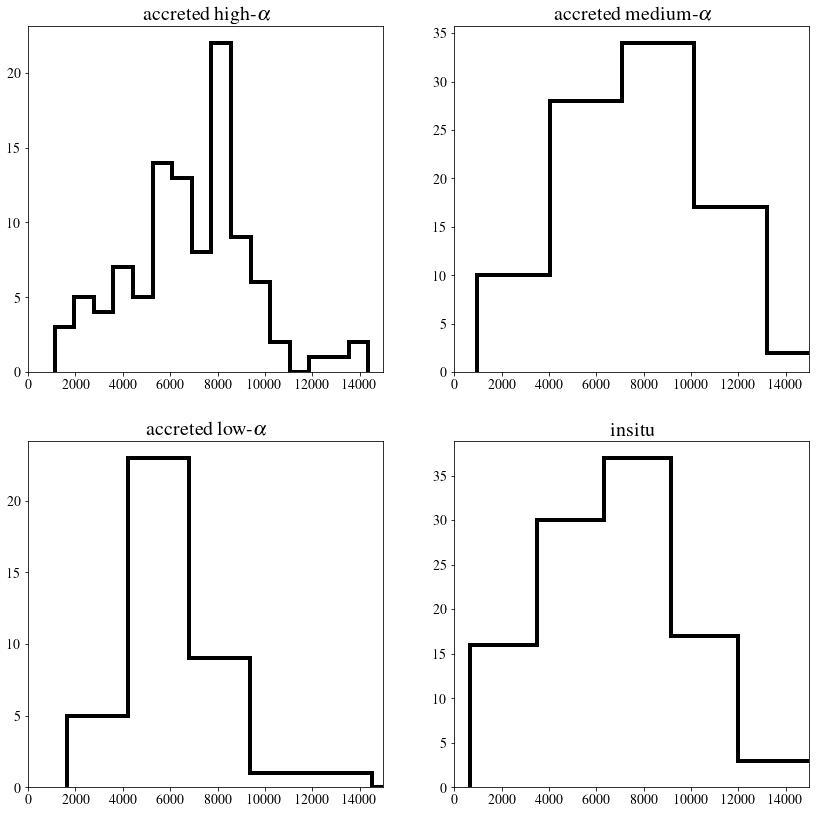

In [156]:
plt.figure(figsize=(14,14), facecolor='white')

plt.subplot(2,2,1)
plt.title(r'accreted high-$\alpha$', fontsize=20)
plt.hist(allstar['weighted_dist'][m_acc_higha][m_un_higha], 16,color='k', histtype='step',lw=4)
plt.xlim(0,15000)

plt.subplot(2,2,2)
plt.title(r'accreted medium-$\alpha$', fontsize=20)
plt.hist(allstar['weighted_dist'][m_acc_mea][m_un_mea], 16,color='k', histtype='step',lw=4)
plt.xlim(0,15000)

plt.subplot(2,2,3)
plt.title(r'accreted low-$\alpha$', fontsize=20)
plt.hist(allstar['weighted_dist'][m_acc_lowa][m_un_lowa], 16,color='k', histtype='step',lw=4)
plt.xlim(0,15000)

plt.subplot(2,2,4)
plt.title(r'insitu', fontsize=20)
plt.hist(allstar['weighted_dist'][m_insitu][m_un_insitu], 16,color='k', histtype='step',lw=4)
plt.xlim(0,15000)

Text(0, 0.5, '$f_{(x)}$')

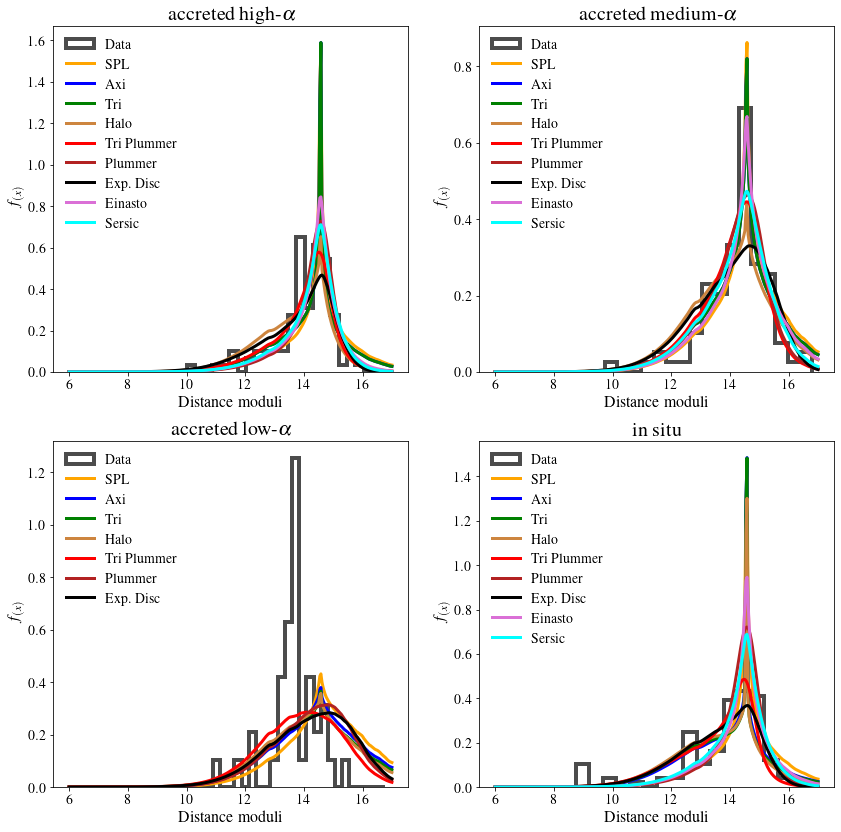

In [157]:
plt.figure(figsize=(14,14), facecolor='white')

plt.subplot(2,2,1)
plt.title(r'accreted high-$\alpha$', fontsize=20)
data_distmod= 5*np.log10(allstar['weighted_dist'][m_acc_higha][m_un_higha]/10.)
iqr = np.percentile(data_distmod, [25,50,75])
h = 2 * (iqr[2]-iqr[0]) / (len(distmods))**0.33
plt.hist(data_distmod, density=True, bins=np.arange(distmods[0],distmods[-1],h), color='k', histtype='step',lw=4., alpha=0.7 , label='Data')
plt.plot(distmods,acc_higha_spl_pd,lw=3., color='orange', label='SPL')
plt.plot(distmods,acc_higha_axi_pd,lw=3., color='b', label='Axi')
plt.plot(distmods,acc_higha_tri_pd,lw=3., color='g', label='Tri')
plt.plot(distmods,acc_higha_halo_pd,lw=3., color='peru', label='Halo')
plt.plot(distmods,acc_higha_triplummer_pd,lw=3., color='r', label='Tri Plummer')
plt.plot(distmods,acc_higha_plummer_pd,lw=3., color='firebrick', label='Plummer')
plt.plot(distmods,acc_higha_expdisc_pd,lw=3., color='k', label='Exp. Disc')
plt.plot(distmods,acc_higha_einasto_pd,lw=3., color='orchid', label='Einasto')
plt.plot(distmods,acc_higha_sersic_pd,lw=3., color='cyan', label='Sersic')

plt.legend(frameon=False,loc='upper left')
plt.xlabel('Distance moduli',fontsize=16)
plt.ylabel(r'$f_{(x)}$',fontsize=16)

plt.subplot(2,2,2)
plt.title(r'accreted medium-$\alpha$', fontsize=20)
data_distmod= 5*np.log10(allstar['weighted_dist'][m_acc_mea][m_un_mea]/10.)
iqr = np.percentile(data_distmod, [25,50,75])
h = 2 * (iqr[2]-iqr[0]) / (len(distmods))**0.33
plt.hist(data_distmod, density=True, bins=np.arange(distmods[0],distmods[-1],h), color='k', histtype='step',lw=4., alpha=0.7 , label='Data')
plt.plot(distmods,acc_mea_spl_pd,lw=3., color='orange', label='SPL')
plt.plot(distmods,acc_mea_axi_pd,lw=3., color='b', label='Axi')
plt.plot(distmods,acc_mea_tri_pd,lw=3., color='g', label='Tri')
plt.plot(distmods,acc_mea_halo_pd,lw=3., color='peru', label='Halo')
plt.plot(distmods,acc_mea_triplummer_pd,lw=3., color='r', label='Tri Plummer')
plt.plot(distmods,acc_mea_plummer_pd,lw=3., color='firebrick', label='Plummer')
plt.plot(distmods,acc_mea_expdisc_pd,lw=3., color='k', label='Exp. Disc')
plt.plot(distmods,acc_mea_einasto_pd,lw=3., color='orchid', label='Einasto')
plt.plot(distmods,acc_mea_sersic_pd,lw=3., color='cyan', label='Sersic')

plt.legend(frameon=False,loc='upper left')
plt.xlabel('Distance moduli',fontsize=16)
plt.ylabel(r'$f_{(x)}$',fontsize=16)

plt.subplot(2,2,3)
plt.title(r'accreted low-$\alpha$', fontsize=20)
data_distmod= 5*np.log10(allstar['weighted_dist'][m_acc_lowa][m_un_lowa]/10.)
iqr = np.percentile(data_distmod, [25,50,75])
h = 2 * (iqr[2]-iqr[0]) / (len(distmods))**0.33
plt.hist(data_distmod, density=True, bins=np.arange(distmods[0],distmods[-1],h), color='k', histtype='step',lw=4., alpha=0.7 , label='Data')
plt.plot(distmods,acc_lowa_spl_pd,lw=3., color='orange', label='SPL')
plt.plot(distmods,acc_lowa_axi_pd,lw=3., color='b', label='Axi')
plt.plot(distmods,acc_lowa_tri_pd,lw=3., color='g', label='Tri')
plt.plot(distmods,acc_lowa_halo_pd,lw=3., color='peru', label='Halo')
plt.plot(distmods,acc_lowa_triplummer_pd,lw=3., color='r', label='Tri Plummer')
plt.plot(distmods,acc_lowa_plummer_pd,lw=3., color='firebrick', label='Plummer')
plt.plot(distmods,acc_lowa_expdisc_pd,lw=3., color='k', label='Exp. Disc')
# plt.plot(distmods,acc_mea_plummer_pd,lw=3., color='firebrick', label='Plummer')
# plt.plot(distmods,acc_mea_expdisc_pd,lw=3., color='k', label='Exp. Disc')
# plt.plot(distmods,acc_mea_einasto_pd,lw=3., color='orchid', label='Einasto')
# plt.plot(distmods,acc_mea_sersic_pd,lw=3., color='cyan', label='Sersic')

plt.legend(frameon=False,loc='upper left')
plt.xlabel('Distance moduli',fontsize=16)
plt.ylabel(r'$f_{(x)}$',fontsize=16)

plt.subplot(2,2,4)
plt.title('in situ', fontsize=20)
data_distmod= 5*np.log10(allstar['weighted_dist'][m_insitu][m_un_insitu]/10.)
iqr = np.percentile(data_distmod, [25,50,75])
h = 2 * (iqr[2]-iqr[0]) / (len(distmods))**0.33
plt.hist(data_distmod, density=True, bins=np.arange(distmods[0],distmods[-1],h), color='k', histtype='step',lw=4., alpha=0.7 , label='Data')
plt.plot(distmods,insitu_spl_pd,lw=3., color='orange', label='SPL')
plt.plot(distmods,insitu_axi_pd,lw=3., color='b', label='Axi')
plt.plot(distmods,insitu_tri_pd,lw=3., color='g', label='Tri')
plt.plot(distmods,insitu_halo_pd,lw=3., color='peru', label='Halo')
plt.plot(distmods,insitu_triplummer_pd,lw=3., color='r', label='Tri Plummer')
plt.plot(distmods,insitu_plummer_pd,lw=3., color='firebrick', label='Plummer')
plt.plot(distmods,insitu_expdisc_pd,lw=3., color='k', label='Exp. Disc')
plt.plot(distmods,insitu_einasto_pd,lw=3., color='orchid', label='Einasto')
plt.plot(distmods,insitu_sersic_pd,lw=3., color='cyan', label='Sersic')

plt.legend(frameon=False,loc='upper left')
plt.xlabel('Distance moduli',fontsize=16)
plt.ylabel(r'$f_{(x)}$',fontsize=16)



Text(0, 0.5, '$f_{(x)}$')

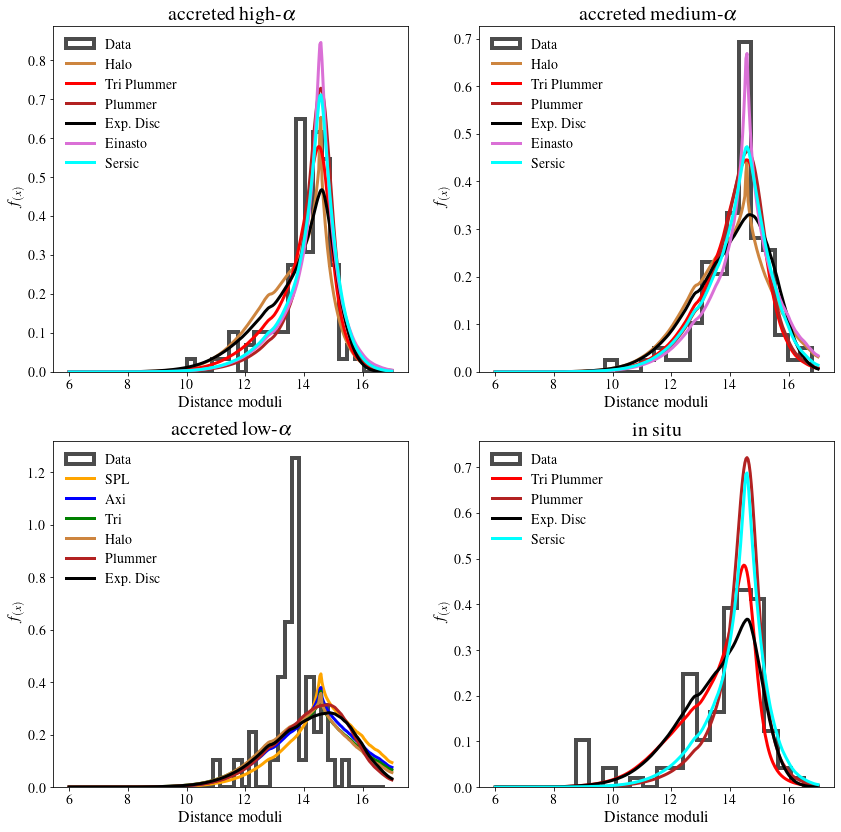

In [158]:
plt.figure(figsize=(14,14), facecolor='white')

plt.subplot(2,2,1)
plt.title(r'accreted high-$\alpha$', fontsize=20)
data_distmod= 5*np.log10(allstar['weighted_dist'][m_acc_higha][m_un_higha]/10.)
iqr = np.percentile(data_distmod, [25,50,75])
h = 2 * (iqr[2]-iqr[0]) / (len(distmods))**0.33
plt.hist(data_distmod, density=True, bins=np.arange(distmods[0],distmods[-1],h), color='k', histtype='step',lw=4., alpha=0.7 , label='Data')
# plt.plot(distmods,acc_higha_spl_pd,lw=3., color='orange', label='SPL')
# plt.plot(distmods,acc_higha_axi_pd,lw=3., color='b', label='Axi')
# plt.plot(distmods,acc_higha_tri_pd,lw=3., color='g', label='Tri')
plt.plot(distmods,acc_higha_halo_pd,lw=3., color='peru', label='Halo')
plt.plot(distmods,acc_higha_triplummer_pd,lw=3., color='r', label='Tri Plummer')
plt.plot(distmods,acc_higha_plummer_pd,lw=3., color='firebrick', label='Plummer')
plt.plot(distmods,acc_higha_expdisc_pd,lw=3., color='k', label='Exp. Disc')
plt.plot(distmods,acc_higha_einasto_pd,lw=3., color='orchid', label='Einasto')
plt.plot(distmods,acc_higha_sersic_pd,lw=3., color='cyan', label='Sersic')

plt.legend(frameon=False,loc='upper left')
plt.xlabel('Distance moduli',fontsize=16)
plt.ylabel(r'$f_{(x)}$',fontsize=16)

plt.subplot(2,2,2)
plt.title(r'accreted medium-$\alpha$', fontsize=20)
data_distmod= 5*np.log10(allstar['weighted_dist'][m_acc_mea][m_un_mea]/10.)
iqr = np.percentile(data_distmod, [25,50,75])
h = 2 * (iqr[2]-iqr[0]) / (len(distmods))**0.33
plt.hist(data_distmod, density=True, bins=np.arange(distmods[0],distmods[-1],h), color='k', histtype='step',lw=4., alpha=0.7 , label='Data')
# plt.plot(distmods,acc_mea_spl_pd,lw=3., color='orange', label='SPL')
# plt.plot(distmods,acc_mea_axi_pd,lw=3., color='b', label='Axi')
# plt.plot(distmods,acc_mea_tri_pd,lw=3., color='g', label='Tri')
plt.plot(distmods,acc_mea_halo_pd,lw=3., color='peru', label='Halo')
plt.plot(distmods,acc_mea_triplummer_pd,lw=3., color='r', label='Tri Plummer')
plt.plot(distmods,acc_mea_plummer_pd,lw=3., color='firebrick', label='Plummer')
plt.plot(distmods,acc_mea_expdisc_pd,lw=3., color='k', label='Exp. Disc')
plt.plot(distmods,acc_mea_einasto_pd,lw=3., color='orchid', label='Einasto')
plt.plot(distmods,acc_mea_sersic_pd,lw=3., color='cyan', label='Sersic')

plt.legend(frameon=False,loc='upper left')
plt.xlabel('Distance moduli',fontsize=16)
plt.ylabel(r'$f_{(x)}$',fontsize=16)

plt.subplot(2,2,3)
plt.title(r'accreted low-$\alpha$', fontsize=20)
data_distmod= 5*np.log10(allstar['weighted_dist'][m_acc_lowa][m_un_lowa]/10.)
iqr = np.percentile(data_distmod, [25,50,75])
h = 2 * (iqr[2]-iqr[0]) / (len(distmods))**0.33
plt.hist(data_distmod, density=True, bins=np.arange(distmods[0],distmods[-1],h), color='k', histtype='step',lw=4., alpha=0.7 , label='Data')
plt.plot(distmods,acc_lowa_spl_pd,lw=3., color='orange', label='SPL')
plt.plot(distmods,acc_lowa_axi_pd,lw=3., color='b', label='Axi')
plt.plot(distmods,acc_lowa_tri_pd,lw=3., color='g', label='Tri')
plt.plot(distmods,acc_lowa_halo_pd,lw=3., color='peru', label='Halo')
# plt.plot(distmods,acc_lowa_triplummer_pd,lw=3., color='r', label='Tri Plummer')
plt.plot(distmods,acc_lowa_plummer_pd,lw=3., color='firebrick', label='Plummer')
plt.plot(distmods,acc_lowa_expdisc_pd,lw=3., color='k', label='Exp. Disc')

plt.legend(frameon=False,loc='upper left')
plt.xlabel('Distance moduli',fontsize=16)
plt.ylabel(r'$f_{(x)}$',fontsize=16)

plt.subplot(2,2,4)
plt.title('in situ', fontsize=20)
data_distmod= 5*np.log10(allstar['weighted_dist'][m_insitu][m_un_insitu]/10.)
iqr = np.percentile(data_distmod, [25,50,75])
h = 2 * (iqr[2]-iqr[0]) / (len(distmods))**0.33
plt.hist(data_distmod, density=True, bins=np.arange(distmods[0],distmods[-1],h), color='k', histtype='step',lw=4., alpha=0.7 , label='Data')
# plt.plot(distmods,insitu_spl_pd,lw=3., color='orange', label='SPL')
# plt.plot(distmods,insitu_axi_pd,lw=3., color='b', label='Axi')
# plt.plot(distmods,insitu_tri_pd,lw=3., color='g', label='Tri')
# plt.plot(distmods,insitu_halo_pd,lw=3., color='peru', label='Halo')
plt.plot(distmods,insitu_triplummer_pd,lw=3., color='r', label='Tri Plummer')
plt.plot(distmods,insitu_plummer_pd,lw=3., color='firebrick', label='Plummer')
plt.plot(distmods,insitu_expdisc_pd,lw=3., color='k', label='Exp. Disc')
plt.plot(distmods,insitu_sersic_pd,lw=3., color='cyan', label='Sersic')
plt.legend(frameon=False,loc='upper left')
plt.xlabel('Distance moduli',fontsize=16)
plt.ylabel(r'$f_{(x)}$',fontsize=16)



# low-alpha sample is mainly Sagittarius, so ignore

Text(0, 0.5, '$f_{(x)}$')

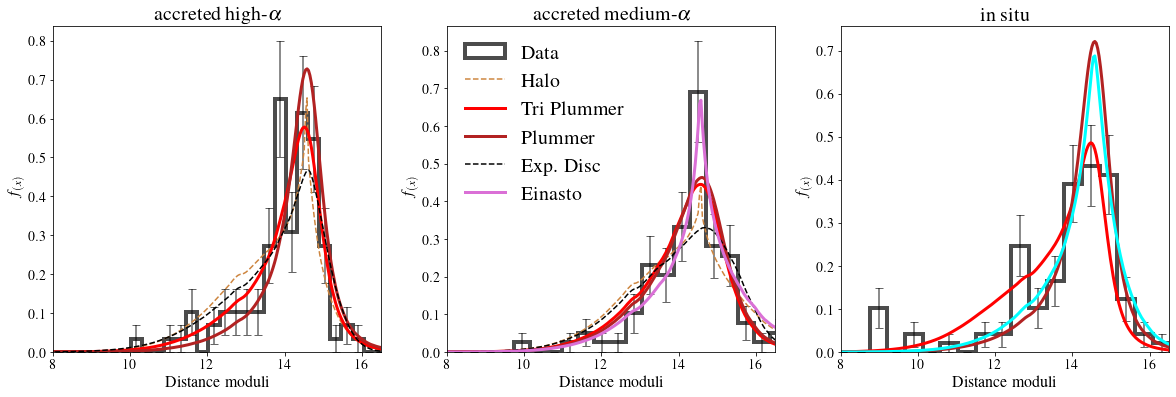

In [172]:
plt.figure(figsize=(20,6), facecolor='white')

plt.subplot(1,3,1)
plt.title(r'accreted high-$\alpha$', fontsize=20)
data_distmod= 5*np.log10(allstar['weighted_dist'][m_acc_higha][m_un_higha]/10.)
iqr = np.percentile(data_distmod, [25,50,75])
h = 2 * (iqr[2]-iqr[0]) / (len(distmods))**0.33
plt.hist(data_distmod, density=True, bins=np.arange(distmods[0],distmods[-1],h), color='k', histtype='step',lw=4., alpha=0.7 , label='Data')
y, bin_edges = np.histogram(data_distmod, bins=np.arange(distmods[0],distmods[-1],h))
bin_centers = 0.5*(bin_edges[1:] + bin_edges[:-1])
dens = y/(np.sum(y)* np.diff(bin_edges))
plt.errorbar(bin_centers,dens, yerr = np.sqrt(y)/(np.sum(y)* np.diff(bin_edges)), marker = '',linestyle='', ecolor='k', capsize=4, alpha=0.6)
# plt.plot(distmods,acc_higha_spl_pd,lw=3., color='orange', label='SPL')
# plt.plot(distmods,acc_higha_axi_pd,lw=3., color='b', label='Axi')
# plt.plot(distmods,acc_higha_tri_pd,lw=3., color='g', label='Tri')
plt.plot(distmods,acc_higha_halo_pd,lw=1.5, color='peru', label='Halo', ls='--')
plt.plot(distmods,acc_higha_triplummer_pd,lw=3., color='r', label='Tri Plummer')
plt.plot(distmods,acc_higha_plummer_pd,lw=3., color='firebrick', label='Plummer')
plt.plot(distmods,acc_higha_expdisc_pd,lw=1.5, color='k', label='Exp. Disc', ls='--')
plt.xlim(8,16.5)

# plt.legend(frameon=False,loc='upper left')
plt.xlabel('Distance moduli',fontsize=16)
plt.ylabel(r'$f_{(x)}$',fontsize=16)

plt.subplot(1,3,2)
plt.title(r'accreted medium-$\alpha$', fontsize=20)
data_distmod= 5*np.log10(allstar['weighted_dist'][m_acc_mea][m_un_mea]/10.)
iqr = np.percentile(data_distmod, [25,50,75])
h = 2 * (iqr[2]-iqr[0]) / (len(distmods))**0.33
plt.hist(data_distmod, density=True, bins=np.arange(distmods[0],distmods[-1],h), color='k', histtype='step',lw=4., alpha=0.7 , label='Data')
y, bin_edges = np.histogram(data_distmod, bins=np.arange(distmods[0],distmods[-1],h))
bin_centers = 0.5*(bin_edges[1:] + bin_edges[:-1])
dens = y/(np.sum(y)* np.diff(bin_edges))
plt.errorbar(bin_centers,dens, yerr = np.sqrt(y)/(np.sum(y)* np.diff(bin_edges)), marker = '',linestyle='', ecolor='k', capsize=4, alpha=0.6)
# plt.plot(distmods,acc_mea_spl_pd,lw=3., color='orange', label='SPL')
# plt.plot(distmods,acc_mea_axi_pd,lw=3., color='b', label='Axi')
# plt.plot(distmods,acc_mea_tri_pd,lw=3., color='g', label='Tri')
plt.plot(distmods,acc_mea_halo_pd,lw=1.5, color='peru', label='Halo', ls='--')
plt.plot(distmods,acc_mea_triplummer_pd,lw=3., color='r', label='Tri Plummer')
plt.plot(distmods,acc_mea_plummer_pd,lw=3., color='firebrick', label='Plummer')
plt.plot(distmods,acc_mea_expdisc_pd,lw=1.5, color='k', label='Exp. Disc', ls='--')
plt.plot(distmods,acc_mea_einasto_pd,lw=3., color='orchid', label='Einasto')
plt.xlim(8,16.5)

plt.legend(frameon=False,loc='upper left', fontsize=20)
plt.xlabel('Distance moduli',fontsize=16)
plt.ylabel(r'$f_{(x)}$',fontsize=16)

plt.subplot(1,3,3)
plt.title('in situ', fontsize=20)
data_distmod= 5*np.log10(allstar['weighted_dist'][m_insitu][m_un_insitu]/10.)
iqr = np.percentile(data_distmod, [25,50,75])
h = 2 * (iqr[2]-iqr[0]) / (len(distmods))**0.33
plt.hist(data_distmod, density=True, bins=np.arange(distmods[0],distmods[-1],h), color='k', histtype='step',lw=4., alpha=0.7 , label='Data')
y, bin_edges = np.histogram(data_distmod, bins=np.arange(distmods[0],distmods[-1],h))
bin_centers = 0.5*(bin_edges[1:] + bin_edges[:-1])
dens = y/(np.sum(y)* np.diff(bin_edges))
plt.errorbar(bin_centers,dens, yerr = np.sqrt(y)/(np.sum(y)* np.diff(bin_edges)), marker = '',linestyle='', ecolor='k', capsize=4, alpha=0.6)
# plt.plot(distmods,insitu_spl_pd,lw=3., color='orange', label='SPL')
# plt.plot(distmods,insitu_axi_pd,lw=3., color='b', label='Axi')
# plt.plot(distmods,insitu_tri_pd,lw=3., color='g', label='Tri')
# plt.plot(distmods,insitu_halo_pd,lw=1.5, color='peru', label='Halo', ls='--')
plt.plot(distmods,insitu_triplummer_pd,lw=3., color='r', label='Tri Plummer')
plt.plot(distmods,insitu_plummer_pd,lw=3., color='firebrick', label='Plummer')
# plt.plot(distmods,insitu_expdisc_pd,lw=1.5, color='k', label='Exp. Disc', ls='--')
plt.plot(distmods,insitu_sersic_pd,lw=3., color='cyan', label='Sersic')
plt.xlim(8,16.5)
# plt.legend(frameon=False,loc='upper left', fontsize=20)
plt.xlabel('Distance moduli',fontsize=16)
plt.ylabel(r'$f_{(x)}$',fontsize=16)



In [162]:
def calc_bic_aic(k, N, lhood):
    
    bic = k * np.log(N) + 2*np.log(lhood) # plus here as we use the minus loglikelihood
    aic = 2*k + 2*np.log(lhood)
    
    return bic, aic

def fit_cells(densprofile, mask1, mask2, init_params = [2.,5.]):
    
    opt_cells = []
    lhood_cells = []
    bic_cells = []
    aic_cells = []
    pd_cells = []
    pdt_cells = []
    rate_cells = [] 

    opt = op.fmin(lambda x: utils.mloglike(x,densprofile, outarea[goodindx_eff]*ds**3.*np.log(10)/5.*(distmods[1]-distmods[0]), Rgrid[goodindx_eff], phigrid[goodindx_eff], zgrid[goodindx_eff], Rphiz[:,0][mask1][mask2],Rphiz[:,1][mask1][mask2], Rphiz[:,2][mask1][mask2]), init_params, full_output=True)
    pd, pdt, rate = pdistmod_model(densprofile,opt[0], outarea, returnrate=True)

    bic, aic = calc_bic_aic(len(opt[0]), len(Rphiz[:,2]), opt[1])                     
                                       
    return opt[0], opt[1], pd, pdt, rate, bic, aic

In [163]:
# exp disc
opt_expdisc_higha, lhood_expdisc_higha, pd_expdisc_higha, pdt_expdisc_higha, rate_expdisc_higha, bic_expdisc_higha, aic_expdisc_higha\
= fit_cells(densprofiles.justexpdisk, m_acc_higha, m_un_higha, init_params = [1/2.2,1/0.8])

# halo
opt_halo_higha, lhood_halo_higha, pd_halo_higha, pdt_halo_higha, rate_halo_higha, bic_halo_higha, aic_halo_higha\
= fit_cells(densprofiles.triaxial_single_cutoff_zvecpa_plusexpdisk, m_acc_higha, m_un_higha, init_params = [2.,1.,0.5,0.5,0.,0.,0.,0.01])

# Plummer
opt_Plummer_higha, lhood_Plummer_higha, pd_Plummer_higha, pdt_Plummer_higha, rate_Plummer_higha, bic_Plummer_higha, aic_Plummer_higha\
= fit_cells(densprofiles.plummer, m_acc_higha, m_un_higha, init_params = [0.1])

# tri Plummer
opt_triPlummer_higha, lhood_triPlummer_higha, pd_triPlummer_higha, pdt_triPlummer_higha, rate_triPlummer_higha, bic_triPlummer_higha, aic_triPlummer_higha\
= fit_cells(densprofiles.plummer_axi, m_acc_higha, m_un_higha, init_params = [0.1,0.,0.])


Optimization terminated successfully.
         Current function value: 842.134999
         Iterations: 32
         Function evaluations: 63
Optimization terminated successfully.
         Current function value: 819.721481
         Iterations: 566
         Function evaluations: 903
Optimization terminated successfully.
         Current function value: 829.139621
         Iterations: 22
         Function evaluations: 44
Optimization terminated successfully.
         Current function value: 812.330594
         Iterations: 167
         Function evaluations: 302


In [164]:
# exp disc
opt_expdisc_mea, lhood_expdisc_mea, pd_expdisc_mea, pdt_expdisc_mea, rate_expdisc_mea, bic_expdisc_mea, aic_expdisc_mea\
= fit_cells(densprofiles.justexpdisk, m_acc_mea, m_un_mea, init_params = [1/2.2,1/0.8])

# halo
opt_halo_mea, lhood_halo_mea, pd_halo_mea, pdt_halo_mea, rate_halo_mea, bic_halo_mea, aic_halo_mea\
= fit_cells(densprofiles.triaxial_single_cutoff_zvecpa_plusexpdisk, m_acc_mea, m_un_mea, init_params = [2.,1.,0.5,0.5,0.,0.,0.,0.01])

# Plummer
opt_Plummer_mea, lhood_Plummer_mea, pd_Plummer_mea, pdt_Plummer_mea, rate_Plummer_mea, bic_Plummer_mea, aic_Plummer_mea\
= fit_cells(densprofiles.plummer, m_acc_mea, m_un_mea, init_params = [0.1])

# tri Plummer
opt_triPlummer_mea, lhood_triPlummer_mea, pd_triPlummer_mea, pdt_triPlummer_mea, rate_triPlummer_mea, bic_triPlummer_mea, aic_triPlummer_mea\
= fit_cells(densprofiles.plummer_axi, m_acc_mea, m_un_mea, init_params = [0.1,0.,0.])

# Einasto
opt_einasto_mea, lhood_einasto_mea, pd_einasto_mea, pdt_einasto_mea, rate_einasto_mea, bic_einasto_mea, aic_einasto_mea\
= fit_cells(densprofiles.einasto, m_acc_mea, m_un_mea, init_params = [2., 5.])


Optimization terminated successfully.
         Current function value: 958.843380
         Iterations: 37
         Function evaluations: 75
Optimization terminated successfully.
         Current function value: 922.763788
         Iterations: 457
         Function evaluations: 759
Optimization terminated successfully.
         Current function value: 929.075966
         Iterations: 24
         Function evaluations: 48
Optimization terminated successfully.
         Current function value: 937.136406
         Iterations: 161
         Function evaluations: 301
Optimization terminated successfully.
         Current function value: 911.877332
         Iterations: 48
         Function evaluations: 91


In [165]:
# exp disc
opt_expdisc_insitu, lhood_expdisc_insitu, pd_expdisc_insitu, pdt_expdisc_insitu, rate_expdisc_insitu, bic_expdisc_insitu, aic_expdisc_insitu\
= fit_cells(densprofiles.justexpdisk, m_insitu, m_un_insitu, init_params = [1/2.2,1/0.8])

# halo
opt_halo_insitu, lhood_halo_insitu, pd_halo_insitu, pdt_halo_insitu, rate_halo_insitu, bic_halo_insitu, aic_halo_insitu\
= fit_cells(densprofiles.triaxial_single_cutoff_zvecpa_plusexpdisk, m_insitu, m_un_insitu, init_params = [2.,1.,0.5,0.5,0.,0.,0.,0.01])

# Plummer
opt_Plummer_insitu, lhood_Plummer_insitu, pd_Plummer_insitu, pdt_Plummer_insitu, rate_Plummer_insitu, bic_Plummer_insitu, aic_Plummer_insitu\
= fit_cells(densprofiles.plummer, m_insitu, m_un_insitu, init_params = [0.1])

# tri Plummer
opt_triPlummer_insitu, lhood_triPlummer_insitu, pd_triPlummer_insitu, pdt_triPlummer_insitu, rate_triPlummer_insitu, bic_triPlummer_insitu, aic_triPlummer_insitu\
= fit_cells(densprofiles.plummer_axi, m_insitu, m_un_insitu, init_params = [0.1,0.,0.])

# Sersic
opt_sersic_insitu, lhood_sersic_insitu, pd_sersic_insitu, pdt_sersic_insitu, rate_sersic_insitu, bic_sersic_insitu, aic_sersic_insitu\
= fit_cells(densprofiles.sersic, m_insitu, m_un_insitu, init_params = [5., 0.5, 5.])


Optimization terminated successfully.
         Current function value: 944.822658
         Iterations: 37
         Function evaluations: 69
Optimization terminated successfully.
         Current function value: 866.290759
         Iterations: 622
         Function evaluations: 962
Optimization terminated successfully.
         Current function value: 921.566736
         Iterations: 22
         Function evaluations: 44
Optimization terminated successfully.
         Current function value: 870.492716
         Iterations: 127
         Function evaluations: 232
Optimization terminated successfully.
         Current function value: 908.524625
         Iterations: 161
         Function evaluations: 298


In [166]:
# acc high-alpha
print('LIKELIHOOD')
print("exp disc: " +str(round(lhood_expdisc_higha,3)))
print("plummer: " +str(round(lhood_Plummer_higha,3)))
print("halo: " +str(round(lhood_halo_higha,3)))
print("Triaxial plummer: " +str(round(lhood_triPlummer_higha,3)))

print('BIC')
print("exp disc: " +str(round(bic_expdisc_higha,3)))
print("plummer: " +str(round(bic_Plummer_higha,3)))
print("halo: " +str(round(bic_halo_higha,3)))
print("Triaxial plummer: " +str(round(bic_triPlummer_higha,3)))

print('AIC')
print("exp disc: " +str(round(aic_expdisc_higha,3)))
print("plummer: " +str(round(aic_Plummer_higha,3)))
print("halo: " +str(round(aic_halo_higha,3)))
print("Triaxial plummer: " +str(round(aic_triPlummer_higha,3)))


LIKELIHOOD
exp disc: 842.135
plummer: 829.14
halo: 819.721
Triaxial plummer: 812.331
BIC
exp disc: 40.484
plummer: 26.947
halo: 121.467
Triaxial plummer: 53.918
AIC
exp disc: 17.472
plummer: 15.441
halo: 29.418
Triaxial plummer: 19.4


In [167]:
# acc medium-alpha
print('LIKELIHOOD')
print("exp disc: " +str(round(lhood_expdisc_mea,3)))
print("plummer: " +str(round(lhood_Plummer_mea,3)))
print("halo: " +str(round(lhood_halo_mea,3)))
print("Triaxial plummer: " +str(round(lhood_triPlummer_mea,3)))
print("Einasto: " +str(round(lhood_einasto_mea,3)))

print('BIC')
print("exp disc: " +str(round(bic_expdisc_mea,3)))
print("plummer: " +str(round(bic_Plummer_mea,3)))
print("halo: " +str(round(bic_halo_mea,3)))
print("Triaxial plummer: " +str(round(bic_triPlummer_mea,3)))
print("Einasto: " +str(round(bic_einasto_mea,3)))

print('AIC')
print("exp disc: " +str(round(aic_expdisc_mea,3)))
print("plummer: " +str(round(aic_Plummer_mea,3)))
print("halo: " +str(round(aic_halo_mea,3)))
print("Triaxial plummer: " +str(round(aic_triPlummer_mea,3)))
print("Einasto: " +str(round(aic_einasto_mea,3)))


LIKELIHOOD
exp disc: 958.843
plummer: 929.076
halo: 922.764
Triaxial plummer: 937.136
Einasto: 911.877
BIC
exp disc: 40.744
plummer: 27.175
halo: 121.704
Triaxial plummer: 54.204
Einasto: 40.643
AIC
exp disc: 17.731
plummer: 15.668
halo: 29.655
Triaxial plummer: 19.686
Einasto: 17.631


In [168]:
# insitu
print('LIKELIHOOD')
print("exp disc: " +str(round(lhood_expdisc_insitu,3)))
print("plummer: " +str(round(lhood_Plummer_insitu,3)))
print("halo: " +str(round(lhood_halo_insitu,3)))
print("Triaxial plummer: " +str(round(lhood_triPlummer_insitu,3)))
print("Sersic: " +str(round(lhood_sersic_insitu,3)))

print('BIC')
print("exp disc: " +str(round(bic_expdisc_insitu,3)))
print("plummer: " +str(round(bic_Plummer_insitu,3)))
print("halo: " +str(round(bic_halo_insitu,3)))
print("Triaxial plummer: " +str(round(bic_triPlummer_insitu,3)))
print("Sersic: " +str(round(bic_sersic_insitu,3)))

print('AIC')
print("exp disc: " +str(round(aic_expdisc_insitu,3)))
print("plummer: " +str(round(aic_Plummer_insitu,3)))
print("halo: " +str(round(aic_halo_insitu,3)))
print("Triaxial plummer: " +str(round(aic_triPlummer_insitu,3)))
print("Sersic: " +str(round(aic_sersic_insitu,3)))


LIKELIHOOD
exp disc: 944.823
plummer: 921.567
halo: 866.291
Triaxial plummer: 870.493
Sersic: 908.525
BIC
exp disc: 40.714
plummer: 27.158
halo: 121.577
Triaxial plummer: 54.057
Sersic: 54.142
AIC
exp disc: 17.702
plummer: 15.652
halo: 29.528
Triaxial plummer: 19.538
Sersic: 19.624


# Fit all three samples with a tri Plummer model

In [58]:
opt_higha_triplummer, samples_higha_triplummer, sampler_higha_triplummer, masses_higha_triplummer, facs_higha_triplummer = fit_bin_mask(m_acc_higha, m_un_higha, fehrange=[-2.,-0.5], effsel=outarea, model=densprofiles.plummer_axi, just_MLE=False, just_MCMC=False, mass=True, init= opt_triPlummer_higha, ncut=100, analytic=False)


102
<function fit_bin_mask.<locals>.<lambda> at 0x6976875e0>
Optimization terminated successfully.
         Current function value: 812.330594
         Iterations: 51
         Function evaluations: 86
[2.28457077 0.9646599  0.5624228 ]


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1441 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

In [105]:
opt_higha_triplummer

(array([2.28457077, 0.9646599 , 0.5624228 ]), 812.3305940137644, 51, 86, 0)

In [59]:
# save the values
np.save('../sav/Nrich-higha-opt_plummer-triaxial', opt_higha_triplummer[0])
np.save('../sav/Nrich-higha-lhood_plummer-triaxial', opt_higha_triplummer[1])
np.save('../sav/Nrich-higha-samples_plummer-triaxial', samples_higha_triplummer)
np.save('../sav/Nrich-higha-sampler_plummer-triaxial', sampler_higha_triplummer)
np.save('../sav/Nrich-higha-masses_plummer-triaxial', masses_higha_triplummer)
np.save('../sav/Nrich-higha-facs_plummer-triaxial', facs_higha_triplummer)

In [93]:
opt_mea_einasto, samples_mea_einasto, sampler_mea_einasto, masses_mea_einasto, facs_mea_einasto = fit_bin_mask(m_acc_mea, m_un_mea, fehrange=[-2.,-0.5], effsel=outarea, model=densprofiles.einasto, just_MLE=False, just_MCMC=False, mass=True, init= opt_einasto_mea, ncut=100, analytic=False)


97
<function fit_bin_mask.<locals>.<lambda> at 0x69ffb8ee0>
Optimization terminated successfully.
         Current function value: 911.877332
         Iterations: 30
         Function evaluations: 57
[9.82812603 5.95712626]


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1441 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

In [106]:
opt_mea_einasto

(array([9.82812603, 5.95712626]), 911.8773315127956, 30, 57, 0)

In [94]:
# save the values
np.save('../sav/Nrich-mediuma-opt_einasto', opt_mea_einasto[0])
np.save('../sav/Nrich-mediuma-lhood_einasto', opt_mea_einasto[1])
np.save('../sav/Nrich-mediuma-samples_einasto', samples_mea_einasto)
np.save('../sav/Nrich-mediuma-sampler_einasto', sampler_mea_einasto)
np.save('../sav/Nrich-mediuma-masses_einasto', masses_mea_einasto)
np.save('../sav/Nrich-mediuma-facs_einasto', facs_mea_einasto)

In [169]:
opt_insitu_triplummer, samples_insitu_triplummer, sampler_insitu_triplummer, masses_insitu_triplummer, facs_insitu_triplummer = fit_bin_mask(m_insitu, m_un_insitu, fehrange=[-2.,-0.5], effsel=outarea, model=densprofiles.plummer_axi, just_MLE=False, just_MCMC=False, mass=True, init= opt_triPlummer_insitu, ncut=100, analytic=False)


107
<function fit_bin_mask.<locals>.<lambda> at 0x69fffc160>
Optimization terminated successfully.
         Current function value: 870.492716
         Iterations: 49
         Function evaluations: 82
[2.15001206 0.61852541 0.352988  ]


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1441 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

In [173]:
# save the values
np.save('../sav/Nrich-insitu-opt_plummer-triaxial', opt_insitu_triplummer[0])
np.save('../sav/Nrich-insitu-lhood_plummer-triaxial', opt_insitu_triplummer[1])
np.save('../sav/Nrich-insitu-samples_plummer-triaxial', samples_insitu_triplummer)
np.save('../sav/Nrich-insitu-sampler_plummer-triaxial', sampler_insitu_triplummer)
np.save('../sav/Nrich-insitu-masses_plummer-triaxial', masses_insitu_triplummer)
np.save('../sav/Nrich-insitu-facs_plummer-triaxial', facs_insitu_triplummer)

In [174]:
from scipy import integrate
def calc_masses(model, facs, samples):
    rthetaphigrid = np.mgrid[0.1:30:150j,0:np.pi:150j,0:2*np.pi:150j]
    dr = (30-0.1)/149
    dtheta = (np.pi-0.)/149
    dphi = (2*np.pi-0.)/149
    deltafactor = rthetaphigrid[0]**2*np.sin(rthetaphigrid[1])*dtheta*dphi #here the rthetaphigrid[:,0]**2*np.sin(rthetaphigrid[:,1]) is the Jacobian
    x = rthetaphigrid[0]*np.sin(rthetaphigrid[1])*np.cos(rthetaphigrid[2])
    y = rthetaphigrid[0]*np.sin(rthetaphigrid[1])*np.sin(rthetaphigrid[2])
    z = rthetaphigrid[0]*np.cos(rthetaphigrid[1])
    rphizgrid = coords.rect_to_cyl(x, y, z)
    halomasses = np.empty((300,150))
    for ii,param in tqdm.tqdm_notebook(enumerate(samples[np.random.choice(len(samples), 300, replace=False)])):
        if model is densprofiles.spherical:
            r = np.linspace(0.1,30,150)
            for jj,rs in enumerate(r):
                rsun = np.sqrt(8.275**2+0.02**2)
                alpha = param[0]
                max_r = 30.
                min_r = 0.1
                r = np.linspace(0.1,30,150)
                integral = 4*np.pi*rsun**alpha*((max_r**(3-alpha))/(3-alpha)-((min_r+rs)**(3-alpha))/(3-alpha))
                masses[ii,jj] = integral*facs[ii]
        elif model is densprofiles.plummer_axi or densprofiles.plummer or model is densprofile.justexpdisk or model is densprofile.axisymmetric or model is densprofile.einasto:
            dens = model(rphizgrid[0], rphizgrid[1], rphizgrid[2], params=param)
            halogriddens = dens*deltafactor
            haloraddens = np.sum(np.sum(halogriddens,axis=2),axis=1)
            halomasses[ii] = haloraddens*facs[ii]
        else:
            dens = model(rphizgrid[0], rphizgrid[1], rphizgrid[2], params=param,split=True)
            halogriddens = dens[0]*deltafactor
            haloraddens = np.sum(np.sum(halogriddens,axis=2),axis=1)
            halomasses[ii] = haloraddens*facs[ii]
    return halomasses

In [175]:
insitu_nrich_mass = calc_masses(densprofiles.plummer_axi, facs_insitu_triplummer, samples_insitu_triplummer)
# higha_nrich_mass = calc_masses(densprofiles.plummer_axi, facs_higha_triplummer, samples_higha_triplummer)
# mea_nrich_mass = calc_masses(densprofiles.einasto, facs_mea_einasto, samples_mea_einasto)


0it [00:00, ?it/s]

In [177]:
print('Within 30kpc')
mass_insitu = np.sum(insitu_nrich_mass,axis=1)
print('In situ: '+str(np.percentile(mass_insitu,[16,50,84])))
mass_higha = np.sum(higha_nrich_mass,axis=1)
print('acc high alpha: '+str(np.percentile(mass_higha,[16,50,84])))
mass_mediuma = np.sum(mea_nrich_mass,axis=1)
print(('acc medium alpha: '+str(np.percentile(mass_mediuma,[16,50,84]))))

Within 30kpc
In situ: [5.62962951e+08 7.82779712e+08 1.08697303e+09]
acc high alpha: [4.43471493e+08 5.90187426e+08 7.61025084e+08]
acc medium alpha: [3.55752883e+08 3.89944386e+08 4.33665556e+08]


In [185]:
mass_insitu_rad = np.sum(insitu_nrich_mass,axis=0)


In [ ]:
# define the shell volumes for which to integrate the mass and density over
rs = np.linspace(0.1,25,150)
shell_volumes = np.zeros(len(rs))
dr = (25-0.1)/149
shell_volumes = [((4*np.pi)/3)*(i+dr)**3-((4*np.pi)/3)*(i)**3 for i in rs]

shell_nrichmasses = acc_nrich_mass/shell_volumes

In [ ]:
percentiles_nrich_masses_shells = np.percentile(shell_nrichmasses,[16,50,84], axis=0)


In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,7))
plt.rc('font',family='serif',size=14)
# plt.plot(rs[:95],percentiles_halo_masses_shell[1][:95]*dr,label='Halo',c='k',lw=3)
# plt.plot(rs[94:],percentiles_halo_masses_shell[1][94:]*dr,c='k',lw=3,ls='dashed')
# plt.fill_between(rs,percentiles_halo_masses_shell[0]*dr,percentiles_halo_masses_shell[2]*dr,alpha=0.3,color='k')
plt.plot(rs,percentiles_nrich_masses_shells[1]*dr,label='N-rich',c='orange',lw=3)
plt.fill_between(rs,percentiles_nrich_masses_shells[0]*dr,percentiles_nrich_masses_shells[2]*dr,alpha=0.3,color='orange')

plt.xlabel(r'r [kpc]',fontsize=18)
plt.legend(fontsize=18,ncol=2,loc='upper center',frameon=False)
plt.tick_params(labelsize=20)
plt.ylabel(r'$\rho_{*}$ [M$\odot$ kpc$^{-3}$]',fontsize=18)
plt.yscale('log')
plt.tick_params(direction='in', right=True,top=True,length=5)
plt.xlim(0.,27)

# plt.savefig('../plots/spherical_annuli_mass_10kpc_erratum.pdf', format='pdf', dpi=400, bbox_inches='tight')

